#Text classification on Reuters Dataset

*Farinola Francesco - MSc in Artificial Intelligence*

*Data mining, Text Mining and Big Data Analytics course - Text mining module*

The purpose of this project is a first approach to the programming language R by exploiting text mining techniques and different ML-DL models for text classification.

We will use the Reuters news dataset.

In the first part, we will investigate the dataset by looking at the class distribution and we will simplify the dataset by keeping only the classes with similar cardinality - this will prevent us from applying oversampling-undersampling on dataset (creating artificial data that can bias the original dataset) or applying class weights for classification.

In the second part, we will examine the text corpus and perform a first objective analysis on the dataset by using LSA and the chi-square test.

Finally, we will test and compare different Machine Learning models and LSTMs and Bi-GRUs to see how they perform on a text classification task over the dataset created.

In [1]:
##WARNING: THIS MAY TAKE A WHILE##
options(warn=-1)
install.packages("keras") #for dataset loading and lstm model
install.packages("tm") #for generic text mining functions
install.packages("SnowballC") #dependency for some tm library functions
install.packages("dplyr") #for data.frame manipulation
install.packages("plyr")
install.packages("caret") #set of functions that attempt to streamline the process for creating predictive models
install.packages("klaR") # for Naive Bayes model
install.packages("kernlab") #for radial and linear SVM models
install.packages("randomForest") #for Random Forest
install.packages("e1071") #for Random Forest
library(plyr)
library(dplyr)
library(keras)
library(tm)
library(SnowballC)
library(caret)
library(klaR)
library(kernlab)
library(randomForest)
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/l

# Load Dataset

First, we will load the Reuter dataset from keras, which provides us two functions for loading it (text data + word index).

We will load the train and test data separately and perform preprocessing and analysis only on train data since test data must be completely unseen for a correct analysis.

In [2]:
#Loads the dataset and the word index
#Dataset is split in train and test by default
c(c(x_train, y_train), c(x_test, y_test)) %<-% dataset_reuters()
word_index <- dataset_reuters_word_index()

#Convert the word index into a dataframe
idx<-unlist(word_index)
dfWords<-as.data.frame(idx)
dfWords$word <- row.names(dfWords)
row.names(dfWords)<-NULL
dfWords <- dfWords[order(dfWords$idx),]

Loaded Tensorflow version 2.8.0



Here, we create the data.frame for train data

In [3]:
dfTrain <- data.frame(y_train)
dfTrain$sentence <- ""
colnames(dfTrain)[1] <- "y"
for (r in 1:length(x_train))
{
  row <- x_train[r]
  line <- ""
  for (i in 1:length(row[[1]]))
  {
     index <- row[[1]][i]
     if (index >= 3)
       line <- paste(line,dfWords[index-3,]$word)
  }
  dfTrain[r,]$sentence <- line
}
write.table(dfTrain,"reuters.train.tab",sep="\t",row.names = FALSE)

Then, do the same for test data

In [4]:
dfTest <- data.frame(y_test)
dfTest$sentence <- ""
colnames(dfTest)[1] <- "y"
for (r in 1:length(x_test))
{
  row <- x_test[r]
  line <- ""
  for (i in 1:length(row[[1]]))
  {
    index <- row[[1]][i]
    if (index >= 3)
      line <- paste(line,dfWords[index-3,]$word)
  }
  dfTest[r,]$sentence <- line
}
write.table(dfTest,"reuters.test.tab",sep="\t",row.names = FALSE)

#Dataset inspection

##Balancing Dataset

In [ ]:
dfTrain <- read.csv("reuters.train.tab", sep="\t", stringsAsFactors = FALSE)
dfTest <- read.csv("reuters.test.tab", sep="\t", stringsAsFactors = FALSE)

We will inspect the dataset to check whether the classes (46 classes) are balanced or not and decide what classes to keep for our task.

In [ ]:
#The function class_counts simply creates a small data.frame - preallocates it for efficiency and memory usage
class_counts <- function(n, dfTrain){
  df_counts <- data.frame(class = numeric(n), counts = numeric(n), stringsAsFactors = FALSE)
  for(i in 1:n){
    df_counts$class[i] <- i
    df_counts$counts[i] <- nrow(filter(dfTrain, y == i))
  }
  df_counts
}

c_counts <-class_counts(45, dfTrain ) #Set 45 since classes go from 1 to 45

As we can see from this plot, dataset is strongly unbalanced, having a number of instances for classes 3,4 extremely high.
We will keep for our task categories with a decent amount of instances per class, avoiding to use classe with really high (will overfit the model) or really low number of instances since those are difficult to predict. 

Also we make this choice to avoid using oversampling and undersampling our dataset and keep the original data - avoid also weights on classes to keep it simple.

The classes chosen will be: 1, 11, 16, 19

Respectively: 'wheat', 'trade', 'crude', 'money-fx'

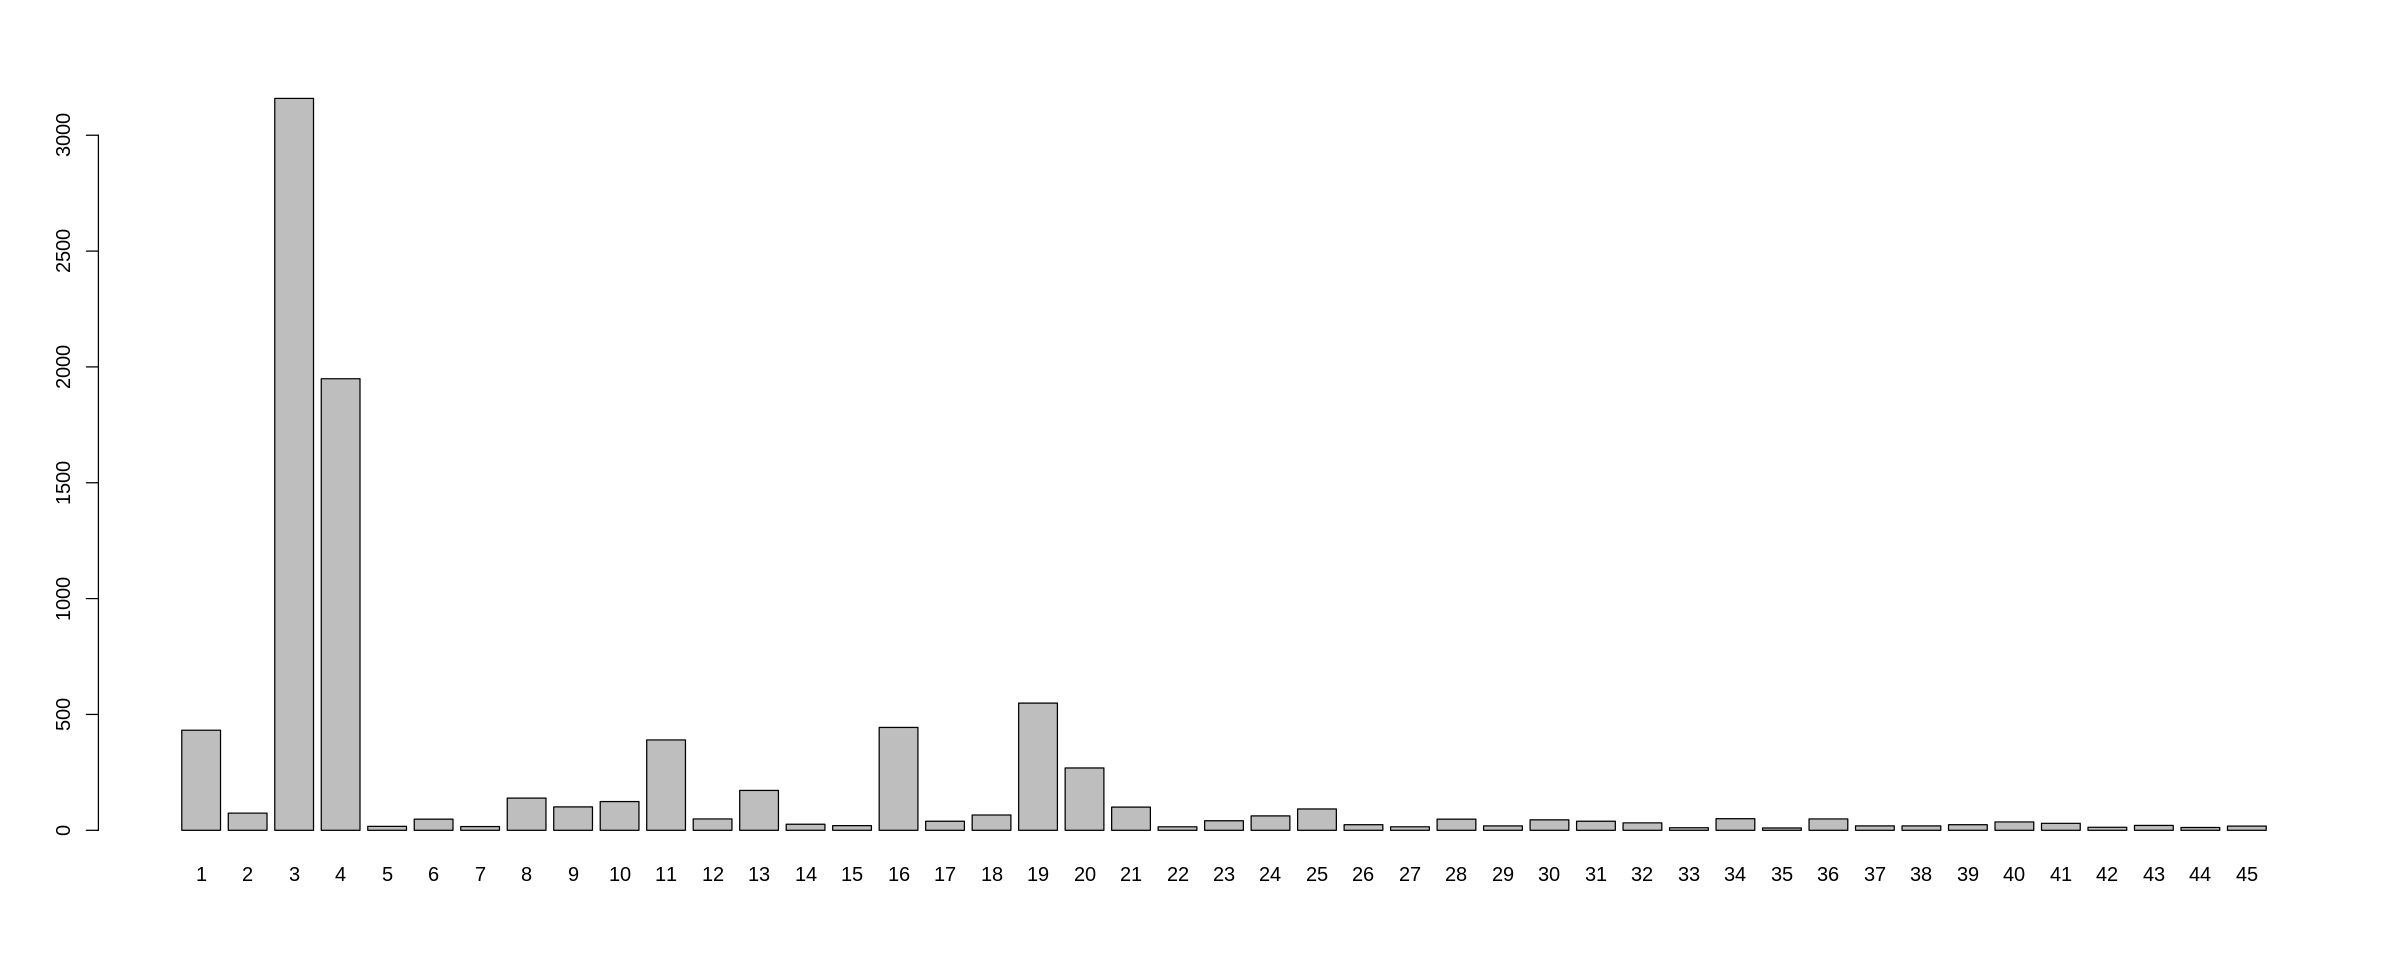

In [ ]:
options(repr.plot.width=20, repr.plot.height=8)
barplot(c_counts$counts, names.arg = c_counts$class)

In the following cells we will filter dfTrain and dfTest with the selected categories.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



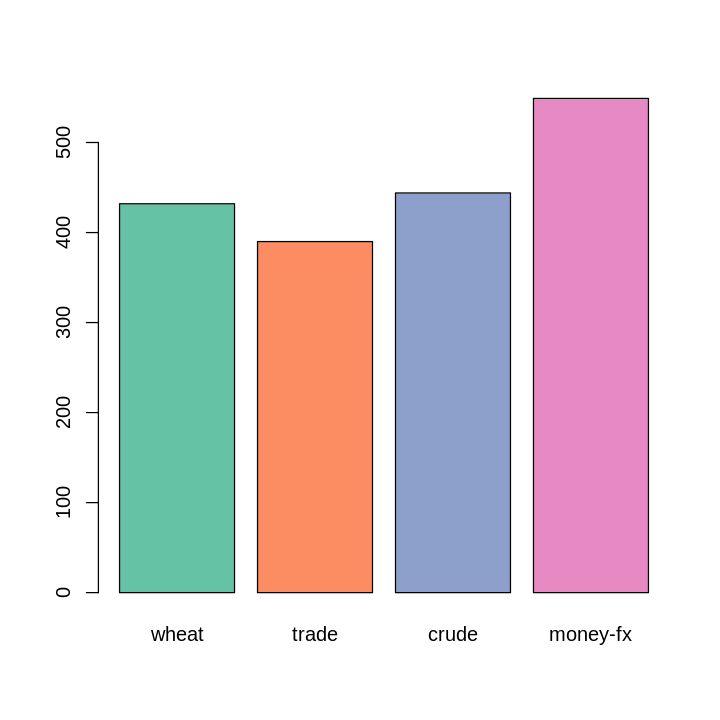

In [ ]:
dfTrain1 <- filter(dfTrain, y==1)
dfTrain1 <- rbind(dfTrain1, mutate(filter(dfTrain, y==11), y=2))
dfTrain1 <- rbind(dfTrain1, mutate(filter(dfTrain, y==16), y=3))
dfTrain1 <- rbind(dfTrain1, mutate(filter(dfTrain, y==19), y=4))
dfTrain <- dfTrain1
c_counts <-class_counts(4, dfTrain)


install.packages("RColorBrewer")
library(RColorBrewer)
coul <- brewer.pal(4, "Set2")
options(repr.plot.width=6, repr.plot.height=6)
barplot(c_counts$counts, names.arg = c("wheat", "trade", "crude", "money-fx"), col=coul)

Let's do the same on Test set

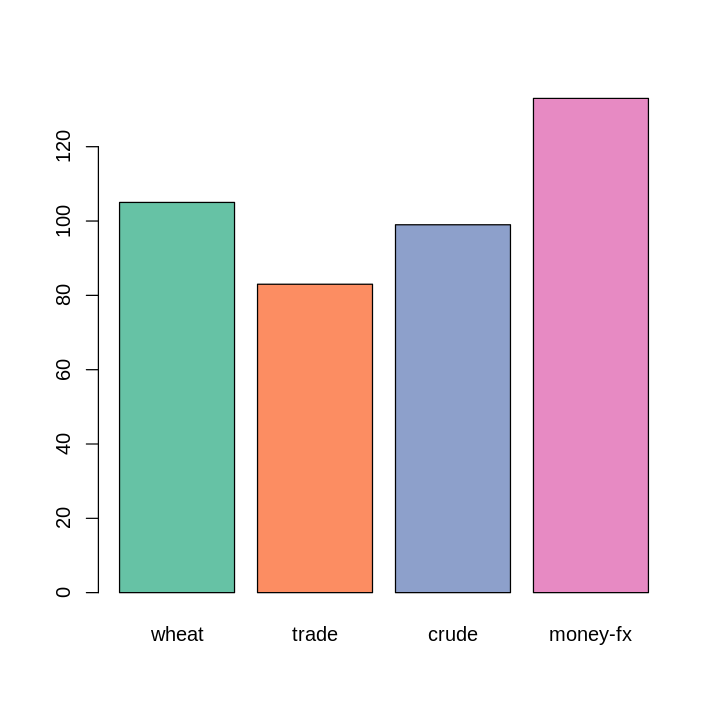

In [ ]:
dfTest1 <- filter(dfTest, y==1)
dfTest1 <- rbind(dfTest1, mutate(filter(dfTest, y==11), y=2))
dfTest1 <- rbind(dfTest1, mutate(filter(dfTest, y==16), y=3))
dfTest1 <- rbind(dfTest1, mutate(filter(dfTest, y==19), y=4))
dfTest <- dfTest1
c_counts_test <-class_counts(4, dfTest)
barplot(c_counts_test$counts, names.arg = c("wheat", "trade", "crude", "money-fx"), col=coul)

##Wordcloud

We will use Wordclouds to inspect the most common words for each class and check whether there are present common words that occur in each of them and may be uninformative

In [ ]:
colnames(dfTrain)[2] <- "text" #Set documents text column name to 'text'
dfTrain$doc_id <- rownames(dfTrain) #Add column doc_id to identify documents

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



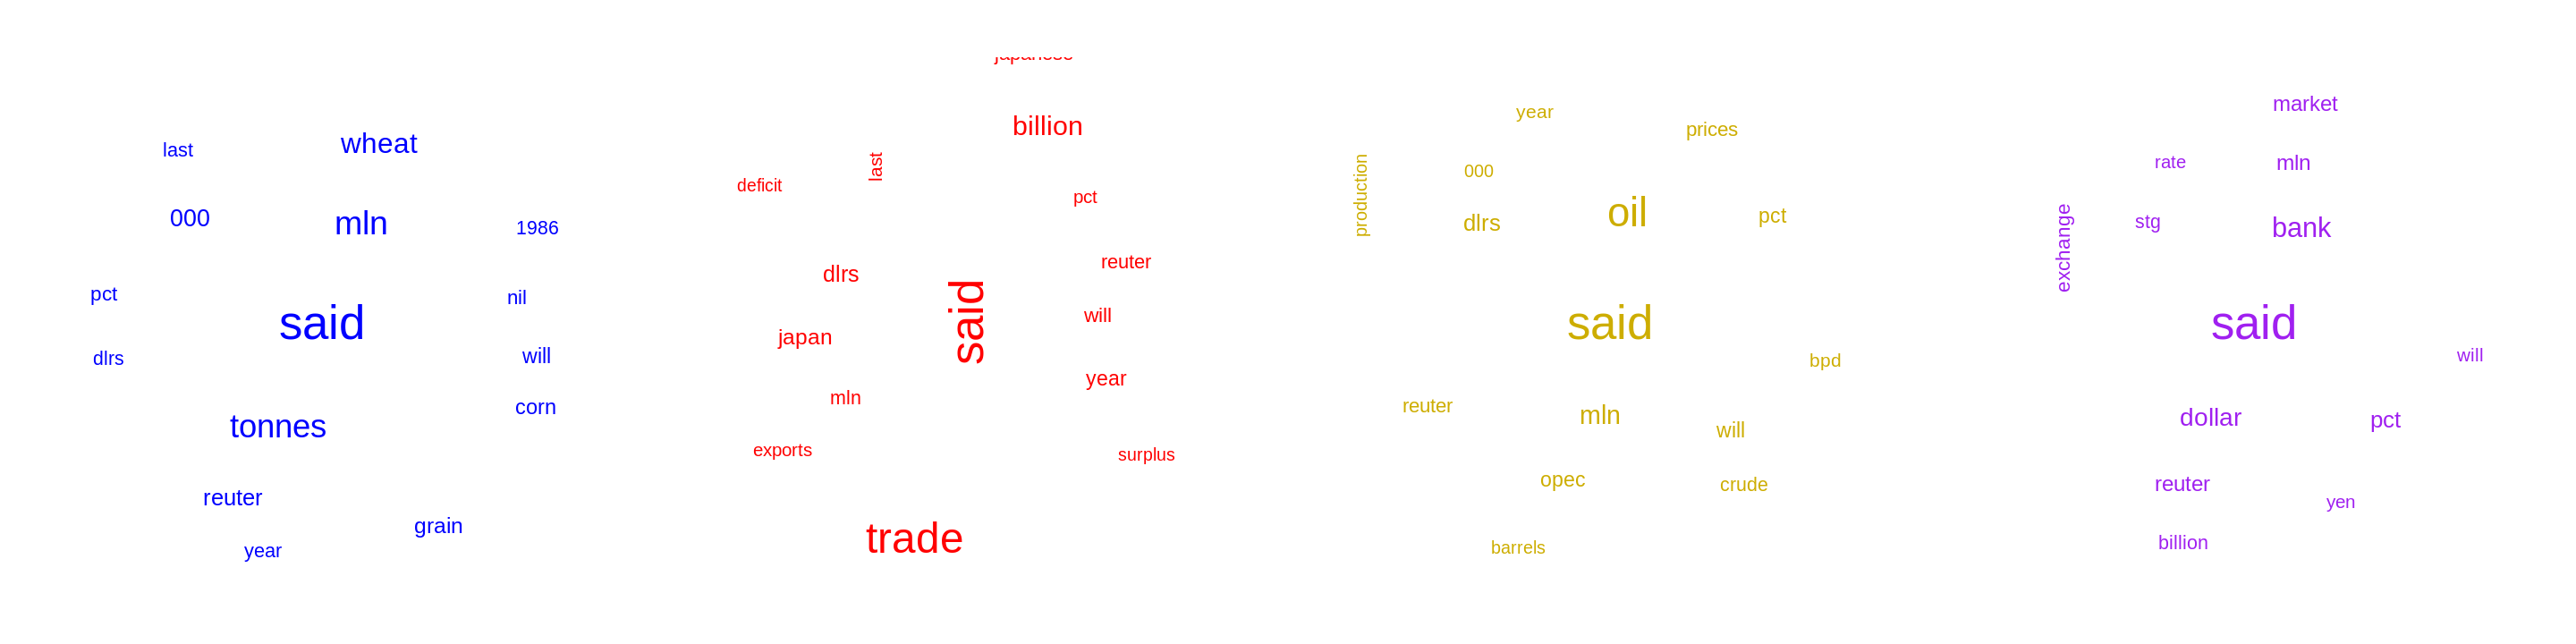

In [ ]:
install.packages("wordcloud")
library(wordcloud)
options(repr.plot.width=24, repr.plot.height=6)
par(mfrow=c(1,4))
wordcloud(filter(dfTrain,y==1)$text, max.words = 15, random.order = FALSE, color="Blue", scale=c(4,1))
wordcloud(filter(dfTrain,y==2)$text, max.words = 15, random.order = FALSE, color="Red", scale=c(4,1))
wordcloud(filter(dfTrain,y==3)$text, max.words = 15, random.order = FALSE, color="Gold3", scale=c(4,1))
wordcloud(filter(dfTrain,y==4)$text, max.words = 15, random.order = FALSE, color="Purple", scale=c(4,1))

From the wordclouds we can see that several words like "said", "reuter", "billion" and "dlrs" are present in documents of all classes, so those might not be useful in the classification task. To get the most meaningful tokens we will apply LSA

##Cleaning Dataset and creating corpus

Define the corpus for train data and perform some text cleaning in the dataset:
* Lower text
* Remove stop words
* Apply stemming
* Remove number
* Remove words that are present in mostly every document and that might mislead our analysis

In [ ]:
corpus <- Corpus(DataframeSource(data.frame(dfTrain[, c(3,2)])))
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, function(x) removeWords(x, stopwords("english")))
corpus <- tm_map(corpus, stemDocument)
corpus <- tm_map(corpus, removeNumbers)
otherWords<- c("said", "billion", "dlrs", "mln", "pct", "reuter")
corpus <- tm_map(corpus, function(x) removeWords(x, otherWords))
corpus

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 1815

#LSA and chi-square test

##Computing Term-Document matrix

In [ ]:
tdm <- TermDocumentMatrix(corpus,control=list(weighting=weightTfIdf))
tdm

<<TermDocumentMatrix (terms: 8376, documents: 1815)>>
Non-/sparse entries: 129030/15073410
Sparsity           : 99%
Maximal term length: 19
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)

For each term, we will retain all terms for which *df_j > N x (1-0.90)* when N is the number of documents

In [ ]:
tdm2<-removeSparseTerms(tdm, 0.90)
inspect(tdm2)

<<TermDocumentMatrix (terms: 131, documents: 1815)>>
Non-/sparse entries: 37821/199944
Sparsity           : 84%
Maximal term length: 10
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)
Sample             :
        Docs
Terms          1645        21        213        241        249        295
  bank   0.20261969 0.0000000 0.00000000 0.00000000 0.00000000 0.00000000
  dollar 0.00000000 0.0000000 0.00000000 0.00000000 0.00000000 0.00000000
  export 0.00000000 0.1304110 0.00000000 0.00000000 0.08906116 0.08694066
  market 0.06905401 0.0000000 0.00000000 0.00000000 0.00000000 0.00000000
  oil    0.00000000 0.0000000 0.00000000 0.00000000 0.00000000 0.00000000
  price  0.00000000 0.0000000 0.00000000 0.00000000 0.00000000 0.00000000
  tonn   0.00000000 0.6103873 0.67211182 0.75959304 0.62527476 0.61038727
  trade  0.00000000 0.0000000 0.00000000 0.00000000 0.00000000 0.00000000
  wheat  0.00000000 0.2080617 0.06545763 0.09709548 0.14209095 0.13870783
  y

In [ ]:
install.packages("lsa")
install.packages("RWeka")
library(lsa)
library(RWeka)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’




With the package 'lsa' we can create the LSA space by choosing autonomously the rank R. The function 'lsa' will create 3 matrices of the SVD decomposion U S V^t:
* U is named tk
* S is named sk
* V is named dk

In [ ]:
words <- rownames(tdm2) # Extracts the words
lsar <- lsa(tdm2)
n <-length(lsar$sk) #Number of eigenvalues computed
n

[1] 40

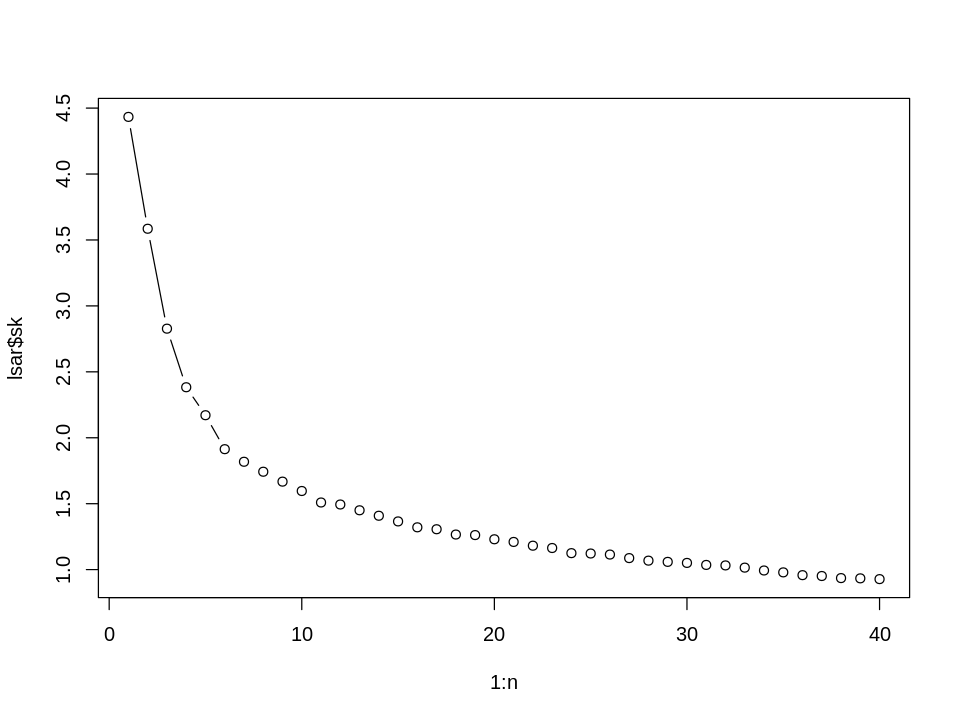

In [ ]:
#Graphs of the eigenvalues computed by the SVD
options(repr.plot.width=8, repr.plot.height=6)
plot(1:n, lsar$sk, type="b")

Here we remember the classes chosen:


*   Wheat = Blue
*   Trade = Red
*   Crude (oil) = Gold
*   Money-FX = Purple

Then, compute the two weighted matrices of terms (tls) and documents (dls) of semantic similarity by the eigenvalues (sk - diagonal of matrix S) 


In [ ]:
y = dfTrain$y
ycols = as.vector(recode(y, '1' = "blue", '2' = "red",  '3' = "gold3", '4' = "purple") )
# let's compute the two weighted matrices, terms and docs, of semantic similarity by the eigenvalues
tls <- lsar$tk %*% diag( lsar$sk )
dls <- lsar$dk %*% diag( lsar$sk )

With the function normrows we normalize the weighted matrices - those are not normalized because achieved by the product with sk. Then, we plot the normalized vectors of terms and docs in the same figure.

We can see from the figure that

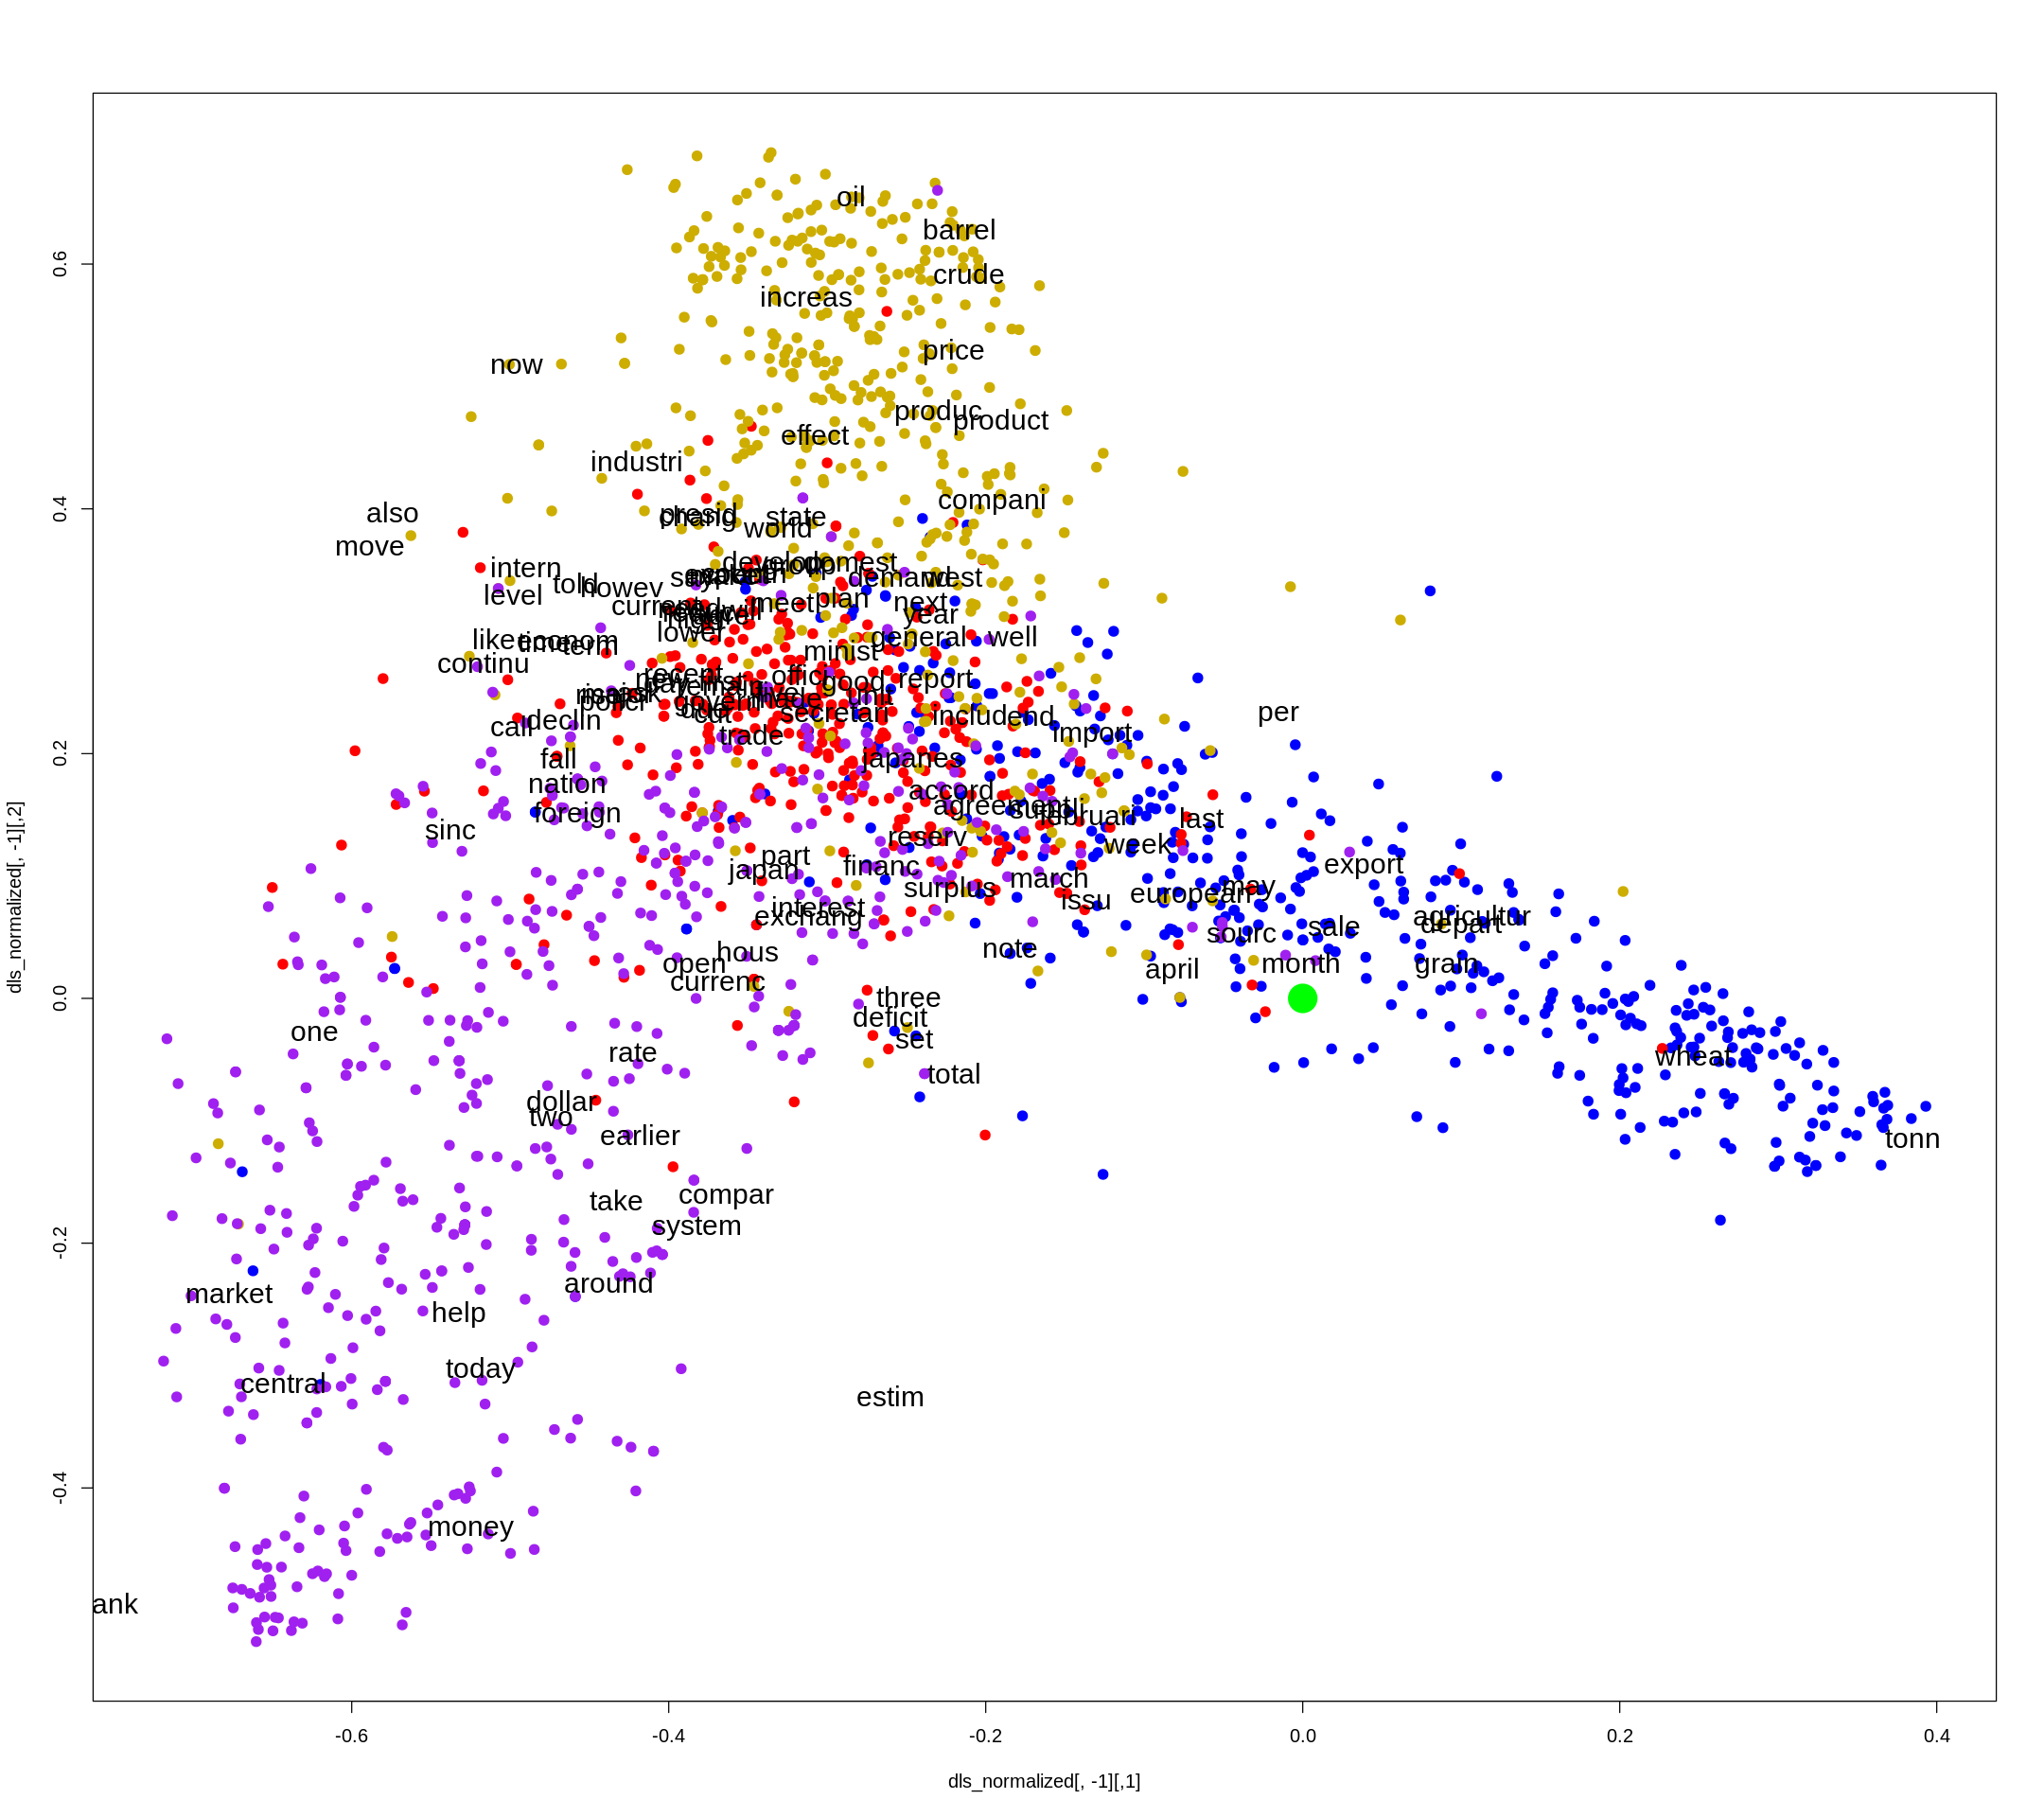

In [ ]:
normrows <- function(x) x / apply(x,1,norm,"2")
tls_normalized <- normrows(tls)
dls_normalized <- normrows(dls)

#Graph of terms and documents weighted matrices
options(repr.plot.width=18, repr.plot.height=16)
plot(dls_normalized[,-1], pch=20, cex=1.7, col=ycols)
text(tls_normalized[,-1], labels=words, cex=1.5)
points( 0, 0, pch=20, cex=5, col="Green")

###Lexical Correlation between the term "import" and various classes

The term "import" appears in the center of an area between the 3 classes "wheat", "trade" and "crude". It might be a good idea to check how much the term "import" correlates to each of these classes by using the chi-square test.

We can clearly see from the results that the term "import" is more correlated with the class "trade" since the probability that the term IS NOT correlated with the class is 2.2e-16, which is much lower than the other two classes.

In [ ]:

import.vs.wheat <- table(as.matrix(tdm2)["import",]>0, y=='1')
dimnames(import.vs.wheat) <- list(import = c("No", "Yes"), wheat = c("No", "Yes"))
chisqtest1 = chisq.test( import.vs.wheat, correct=FALSE )

import.vs.trade <- table(as.matrix(tdm2)["import",]>0, y=='2')
dimnames(import.vs.trade) <- list(import = c("No", "Yes"), trade = c("No", "Yes"))
chisqtest2 = chisq.test( import.vs.trade, correct=FALSE ) 

import.vs.crude <- table(as.matrix(tdm2)["import",]>0, y=='3')
dimnames(import.vs.crude) <- list(import = c("No", "Yes"), crude = c("No", "Yes"))
chisqtest3 = chisq.test( import.vs.crude, correct=FALSE ) 

chisqtest1
chisqtest2
chisqtest3


	Pearson's Chi-squared test

data:  import.vs.wheat
X-squared = 6.816, df = 1, p-value = 0.009034



	Pearson's Chi-squared test

data:  import.vs.trade
X-squared = 258.22, df = 1, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  import.vs.crude
X-squared = 12.912, df = 1, p-value = 0.0003265


Also from expected and observed values for the term in each class, we can see that the term "import" appear most in "trade" documents.

In [ ]:
chisqtest2$expected
chisqtest2$observed 
#184 + 206 "trade" news

,No,Yes
No,1102.314,301.68595
Yes,322.686,88.31405


      trade
import   No  Yes
   No  1220  184
   Yes  205  206

### Closest term to "import"

The term nearest to "import" is the word "well" so we verify if the couple "well import" is objectively correlated to the class "trade". We check this with the lexical correlation as before.

In [ ]:
associate(tls_normalized[,2:3], "import", threshold=0.99)

well      west    effect   increas    demand       end      next     sourc 
0.9999989 0.9998226 0.9993253 0.9986268 0.9965446 0.9963814 0.9961417 0.9960461 
     year   compani    produc    domest     state      week   general 
0.9953303 0.9947828 0.9946266 0.9925881 0.9915362 0.9910084 0.9905157

The p-value equals to 5.977e-10 which means the probability the two terms are not correlated with the class "trade" equals that value.

In [ ]:
well.vs.trade <- table(as.matrix(tdm2)["well",]>0 & as.matrix(tdm2)["import",]>0, y=='2' )
dimnames(well.vs.trade) <- list(well_trade = c("No", "Si"), y = c("No", "Si"))
chisqtest = chisq.test(well.vs.trade, correct=FALSE )
chisqtest


	Pearson's Chi-squared test

data:  well.vs.trade
X-squared = 38.329, df = 1, p-value = 5.977e-10


###Semantic correlation of the couple "well import" (query)

To do so, we transform the query "well import" into a document and do the fold_in in the LSA space

In [ ]:
wiq <- "well import"
wiv <- query(wiq, words) #create the query
wils <- t(wiv) %*% lsar$tk #multiplt it with the matrix U of the LSA space
wils

WELL IMPORT,-0.1071979,-0.07000702,0.1440324,-0.08077208,-0.1952306,-0.001876612,-0.0430906,-0.08339952,0.004873701,0.09139429,⋯,0.1088699,0.1272381,-0.07675622,-0.127926,-0.07903545,0.1337647,0.09199888,-0.2138064,-0.3558602,0.2030968


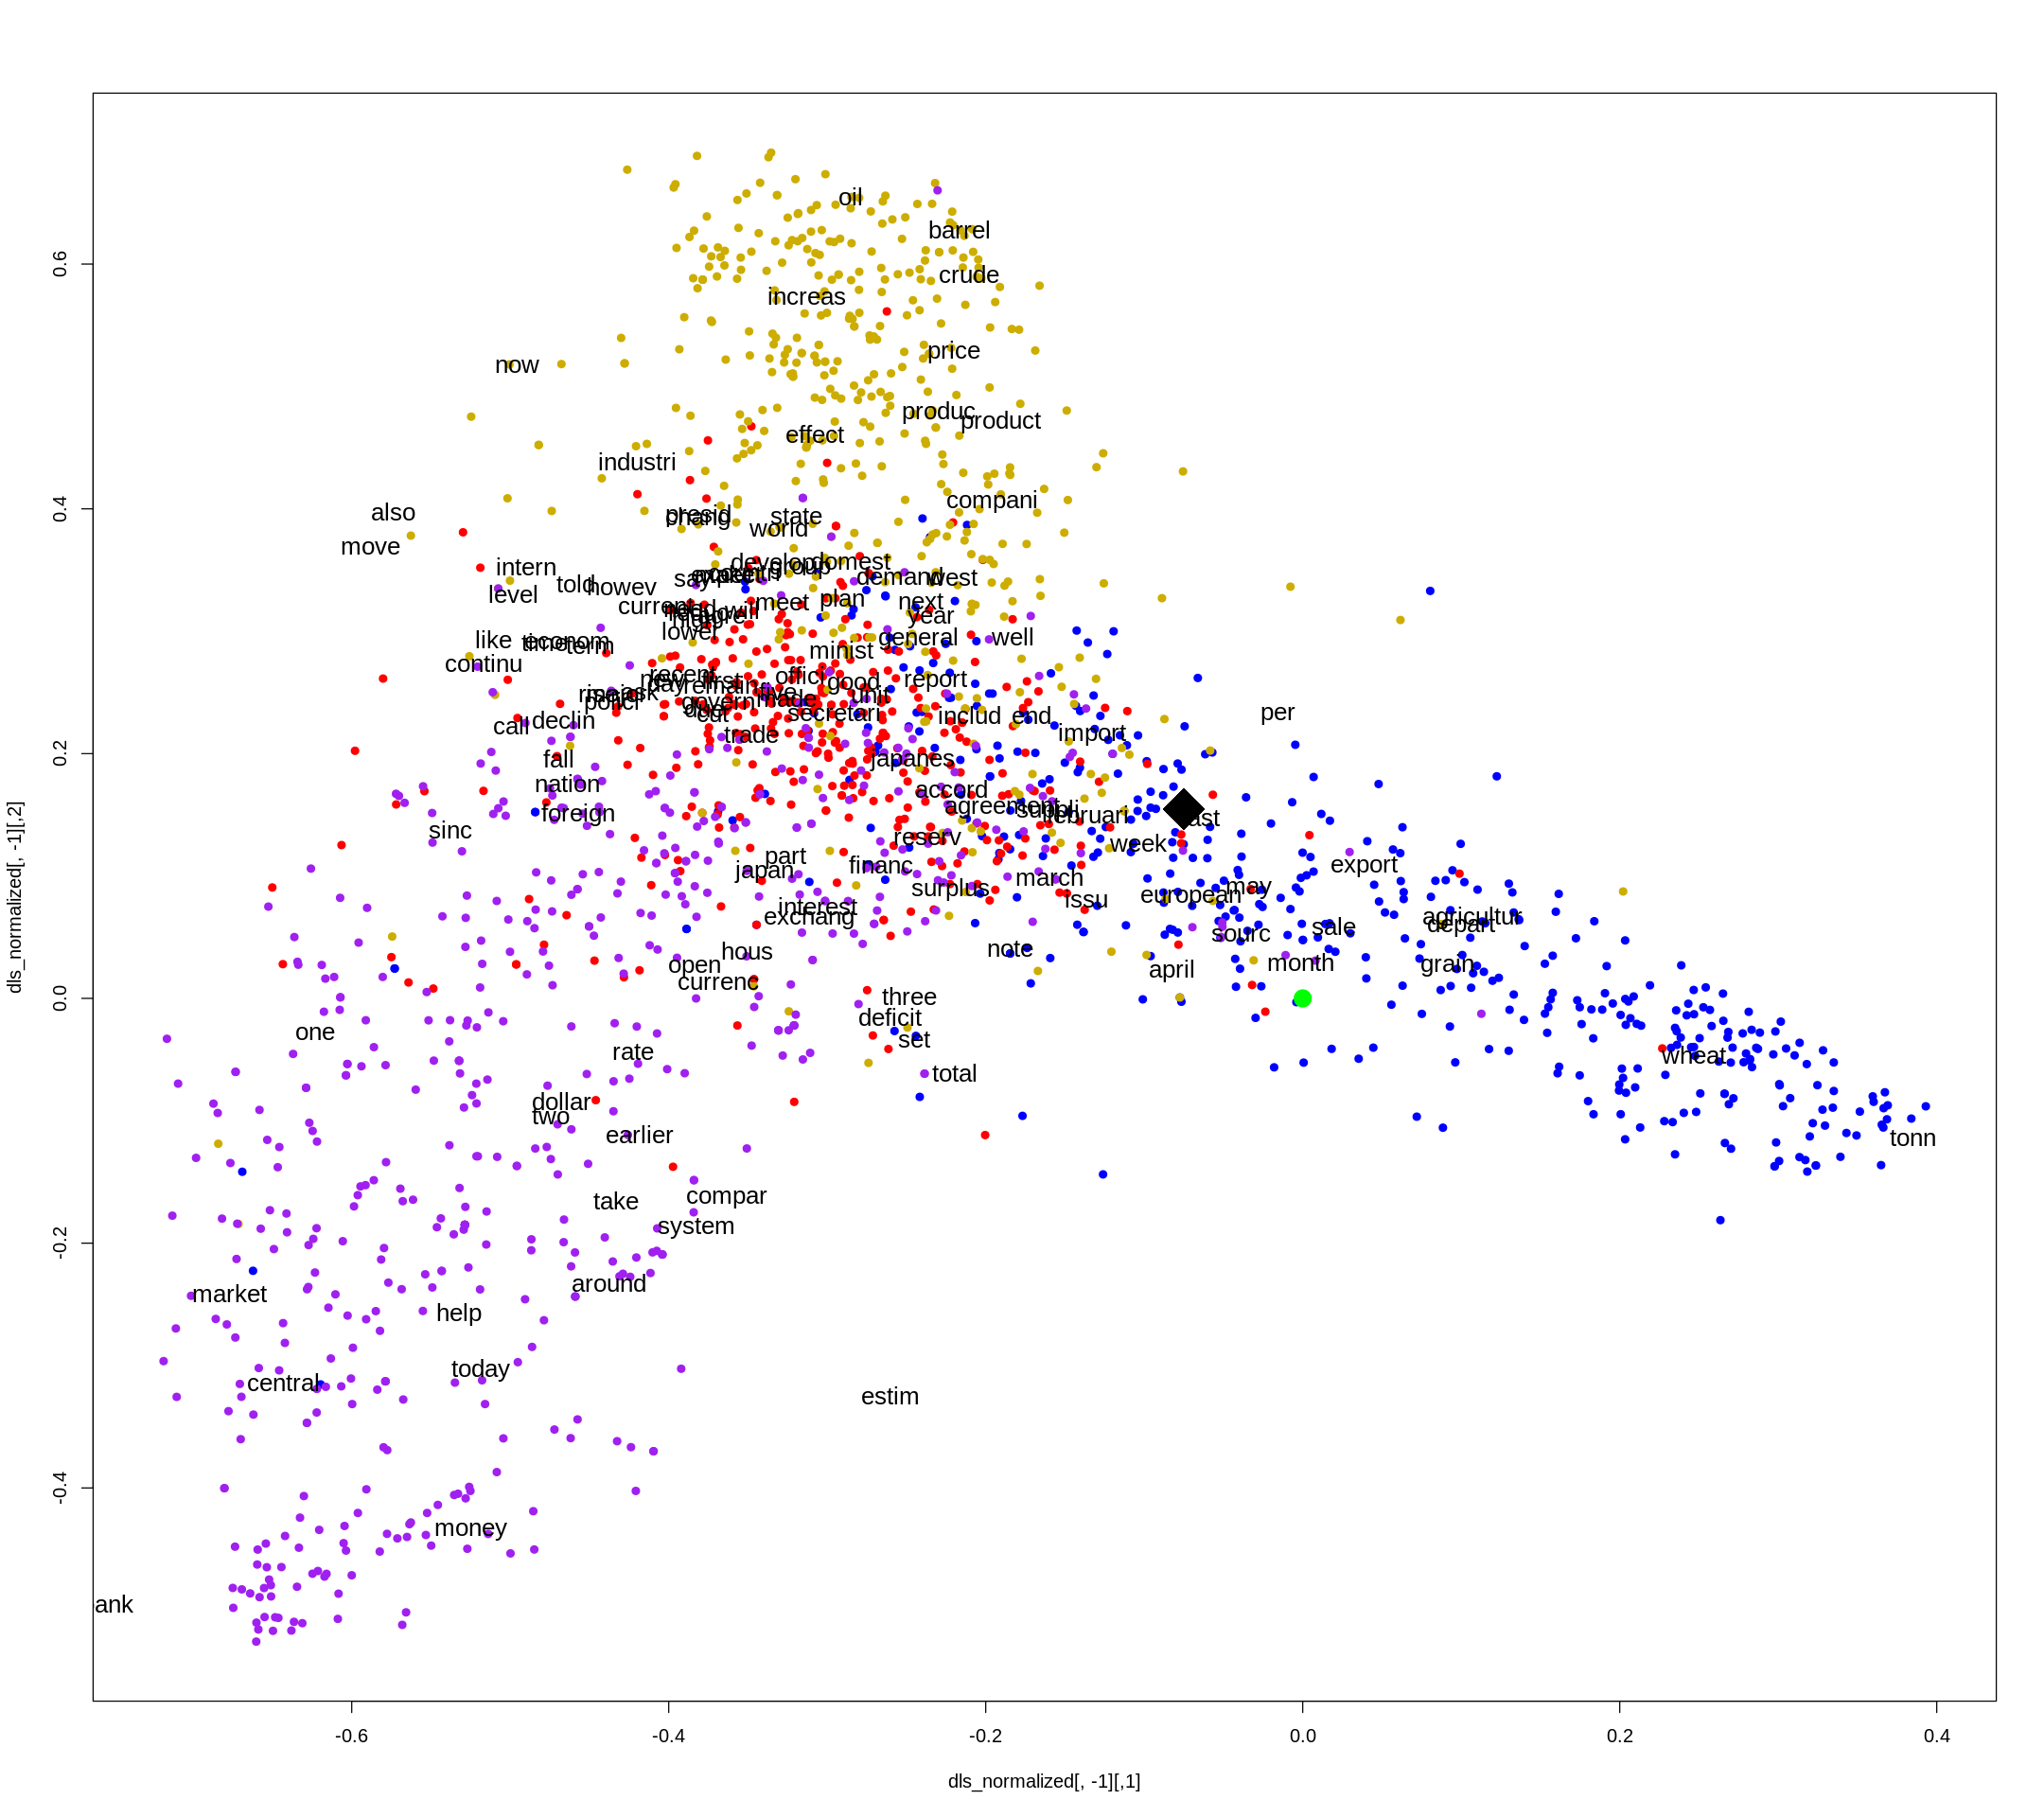

In [ ]:
# graph of the terms and docs in the LSA space using the dimensions 2 and 3
plot(dls_normalized[,-1], pch=20, cex=1.3, col=ycols)
text(tls_normalized[,-1], labels=words, cex=1.3)
points(0,0, pch=20, cex=3, col="green")
wils_normalized <- normrows(wils) #Normalization of vector
points(wils_normalized[2],wils_normalized[3],cex=5,pch=18,col="Black") #Query as a point in the graph

###Find documents semantically similar to the query "well import"

We first define two functions:
* 'cosines' to return the cosine similarity between a query Q and the rows of a matrix X
* 'top' to return the indeces of N max values in X

Then, we use these functions to get the top 5 documents with semantically similar to the query "well import" considering only the 2nd and 3rd dimension in the LSA space.

We can clearly see that the most semantically similar documents are documents related to the class "crude". So we are losing a lot of information by using only two dimensions.

In [ ]:
cosines <- function(X, Q) apply( X, 1, cosine, as.vector(Q) )
top <- function(X, N) order( X, decreasing=TRUE )[1:N]

top( cosines( dls[,2:3], wils[2:3] ), 5 )
dfTrain$text[top(cosines(dls[,2:3], wils[2:3]), 5)]  

[1] 1045 1234 1027  896 1256

[1] " kuwait's oil exports have not been affected by the seven year iran iraq war kuwait oil tanker company kotc chairman and managing director abdul fattah al bader told a kuwaiti newspaper kuwait has exploited all available opportunities to continue exporting its oil without any reduction the al anbaa newspaper quoted him as saying he said kotc made profits of more than two mln dinars seven mln dlrs in the fiscal year ending last june but predicted lower profits this year due to higher costs for chartering and operating vessels reuter 3"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
[2] " shell oil co said first quarter net income dropped 61 pct over the prior year quarter on revenues that slipped four pct lower prices for crude oil and natural gas and reduced margins in our oil and chemical products businesses were the major factor for the earings decline john f bookout president said in a statement for the quarter the company a unit of royal dutch shell group lt rd lt sc earned 108 mln dlrs on sales of 4 50 billion dlrs compared with 276 mln dlrs on sales of 4 67 billion dlrs a year ago bookout said the company is cautiously optimistic oil markets will be less volatile in coming months than they were in 1986 in coming months oil products results should benefit from seasonally higher gasoline volumes he said however so long as u s product inventories remain high it may be difficult to fully recover from the depressed margins of recent periods he added bookout said the company's chemical products earnings should benefit from strong performances in chemical sales volumes and continued high industry operating rates shell said its oil and gas exploration and product segment earned 110 mln dlrs for the quarter vs 91 mln dlrs in 1986 it said earnings were hurt by lower selling prices for crude oil natural gas and natural gas liquids domestic crude oil prices averaged 14 24 dlrs a barrel compared with 19 28 dlrs last year while natural gas prices dropped 24 pct shell said shell said earnings at its oil products segment plunged by 53 mln dlrs to eight mln dlrs it said lower refined product selling prices were only partially offset by reduced raw material costs the company said earnings from chemical products also fell sharply to 40 mln dlrs from 72 mln dlrs due mainly to lower margins especially in commodity chemicals coupled with its pullout from the agricultural chemicals business in october 1986 shell said capital and exploratory outlays totaled 500 mln dlrs for the quarter off from 645 mln dlrs reuter 3"
[3] " ecuador today suspended its crude oil exports indefinitely due to an earthquake 

We might choose an LSA space with more dimensions to lose less information. We have to find the Knee point in the sequence of eigenvalues in the local minimums thanks to the curve function defined by the eigenvalues.
The first local minimum is 4 so we select the first 4 dimensions and see what happens next.

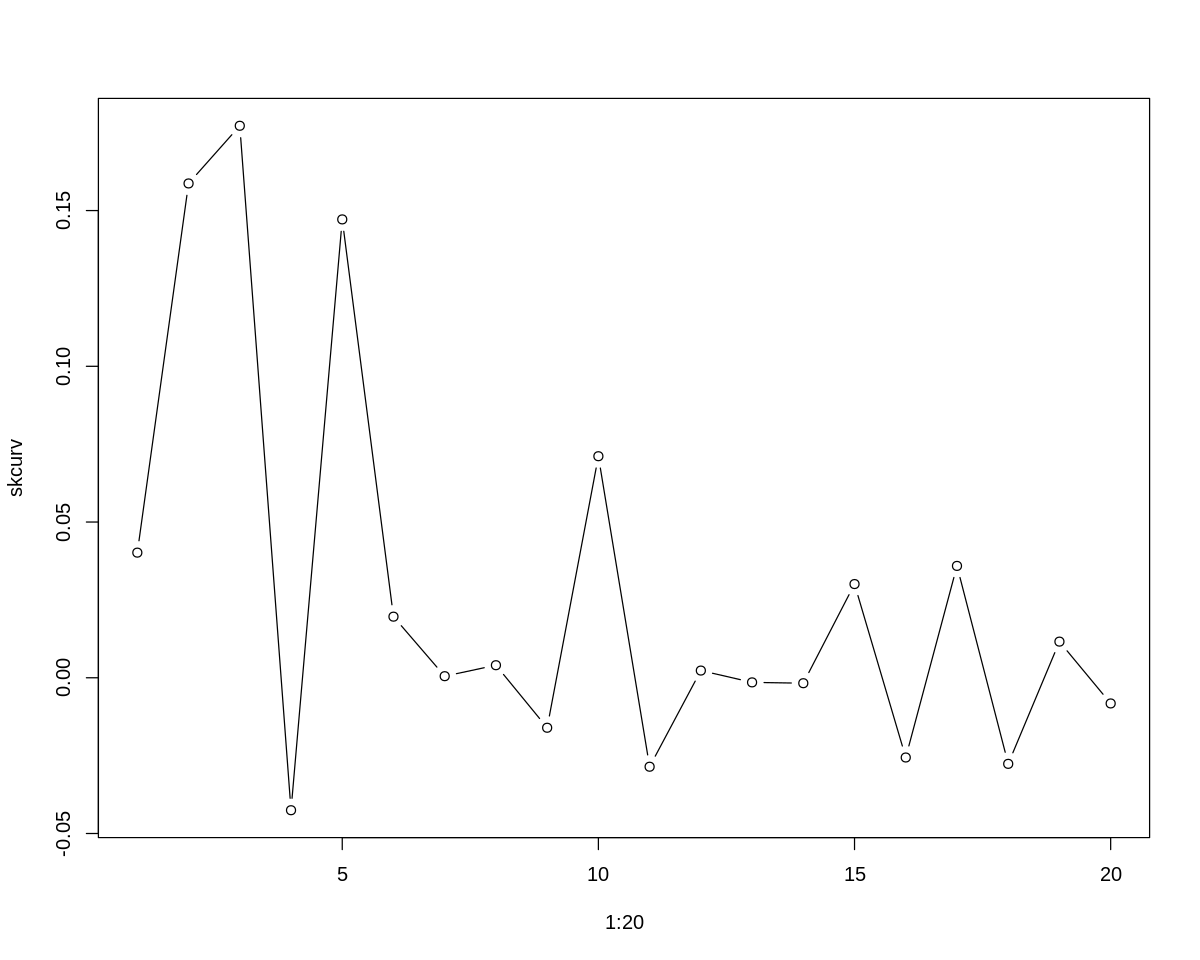

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
fordiff <- function(x) x[2:length(x)] - x[1:(length(x)-1)]
skd <- fordiff(lsar$sk)
skdd <- fordiff(skd)
skcurv <- skdd[1:20] / (1+(skd[1:20])^2)^1.5
plot( 1:20, skcurv, type="b" )

By looking at these results we can clearly see that now the semantically similar documents to the query are from the class "trade".

In [ ]:
dfTrain$text[top(cosines(dls[,1:4], wils[1:4]), 5)]

[1] " pakistani government allowed freer cotton and rice export in a three year new trade policy aimed at narrowing the country's yawning trade gap commerce and planning minister mahbubul haq said in a televised speech the government had also decided to allow duty free import of cotton yarn to make the textile industry more competitive and to link bulk tea imports to the export of pakistani products cotton and rice are pakistan's main exports which have been handled exclusively by state corporations since early 1970s but haq said now the private sector would also export cotton and rice along with the corporations which meets a long standing demand of the local traders the duty free import of cotton yarn has been allowed to bring down prices and help the local ancillary industries compete effectively in the world market he said haq said the new policy effective from the fiscal year 1987 88 beginning on july 1 would be for three years but reviewed every year it was a departure from the previous practice of announcing trade policies for a single fiscal year and haq said it would enable the businessmen to plan their market strategies over a longer period he said an export credit of 250 mln dlrs had been provided for the export of engineering goods to selected third world countries on soft credit terms pakistan's 1986 87 exports at 3 6 billion dlrs 18 2 per cent more than in the previous year and imports at 5 23 billion dlrs compared to 5 63 billion dlrs in 1985 86 he said the government policy was to rationalise and streamline import controls it has been observed that due to restrictions on imports specially on raw materials and intermediate goods local industry has been suffering for want of necessary inputs he said prices have been on the increase and quality of goods produced has been low this restrictive policy also gave rise to smuggling and hampering of exports he said that to correct this situation 136 items had freed from import restrictions previously pakistan has met its trade gap largely from remittances from its nationals working abroad mainly in the gulf however the remittances have begun to fall after the drop in oil prices in recent years leading to the spectre of a balance of payments crisis for pakistan reuter 3"
[2] " japan should increase foreign access to its farm products market while encouraging further development of domestic agriculture a government report said the white paper on agriculture for the year ended march 31 said active participation in writing world farm trade rules at the next round of general agreement on tariffs and trade gatt talks will help prepare japan to improve access agriculture ministry sources said the paper marked an easing in japan's tough position on agricultural imports which stressed the need for strict controls on some products to maintain self sufficiency in food japan now produces only 30 pct of its annual grain needs down from 61 pct some 20 years ago official figures show the paper said japanese agriculture has been slow to improve productivity and demand supply imbalances the relative shortage of farmland in japan is mainly responsible for higher domestic prices it said the strong yen has meant lower input material prices but has also resulted in higher agricultural imports which has worsened working conditions among part time farmers the paper said this could make it difficult to improve the industry's structure the paper said to solve these problems and to reduce farm product prices to more reasonable levels japan should try to restructure the the agricultural sector to improve productivity and make it self supporting it said reuter 3"                                                                                                                                                                                                                                                                                                                                                      

### Semantic correlation between query and class based on ranking

To determine whether there exists a correlation between the query "well import" and class "trade" with a semantic model based on ranking we need to fix the numebr of returned results form the model (R-precision). This is given by the cardinality of "trade" news in the whole dataset. 

We will calculate it for different k values including the total number of "trade" news (390).

We get 204 "trade" news over 58 expected, but this indicates greater or less correlation between "well import" and "trade" news.

In [ ]:
print("k=20")
table(y[top(cosines(dls[,1:4],wils[1:4]), 20)])
print("k=50")
table(y[top(cosines(dls[,1:4],wils[1:4]), 50)])
print("k=100")
table(y[top(cosines(dls[,1:4],wils[1:4]), 100)])
print("k=390 (max)")
table(y[top(cosines(dls[,1:4],wils[1:4]), 390)]) #15% of 390= 58 expected "trade" news

wi_query.vs.trade <- table(1:nrow(dls) %in% top(cosines(dls[,1:4], wils[1:4]), nrow(filter(dfTrain, y==2))), y=='2' )
dimnames(wi_query.vs.trade) <- list(well_import = c("No", "Yes"), y = c("No", "Yes"))
wi_query.vs.trade


[1] "k=20"



 1  2  3  4 
 5 11  2  2 

[1] "k=50"



 1  2  3  4 
12 20 12  6 

[1] "k=100"



 1  2  3  4 
21 48 23  8 

[1] "k=390 (max)"



  1   2   3   4 
 66 204  71  49 

           y
well_import   No  Yes
        No  1239  186
        Yes  186  204

We perform the chi-square test to objectively verify the correlation. 

We obtain that the probability that the couple "well import" is NOT SEMANTICALLY correlated to "trade" news is 2.26e-16 - so the terms well and import are present in 52% of the news.

To verify it, we order the news based on decreasing semantic relevance wrt the query "well import" 

In [ ]:
chisq.test( wi_query.vs.trade, correct=FALSE )


	Pearson's Chi-squared test

data:  wi_query.vs.trade
X-squared = 279.68, df = 1, p-value < 2.2e-16


We can see from the plot that "Trade" news are not focused in the first part of the plot. There are also a lot of news from other classes in the first part.

This suggests that the current query is not so meaningful for the class topic "trade".

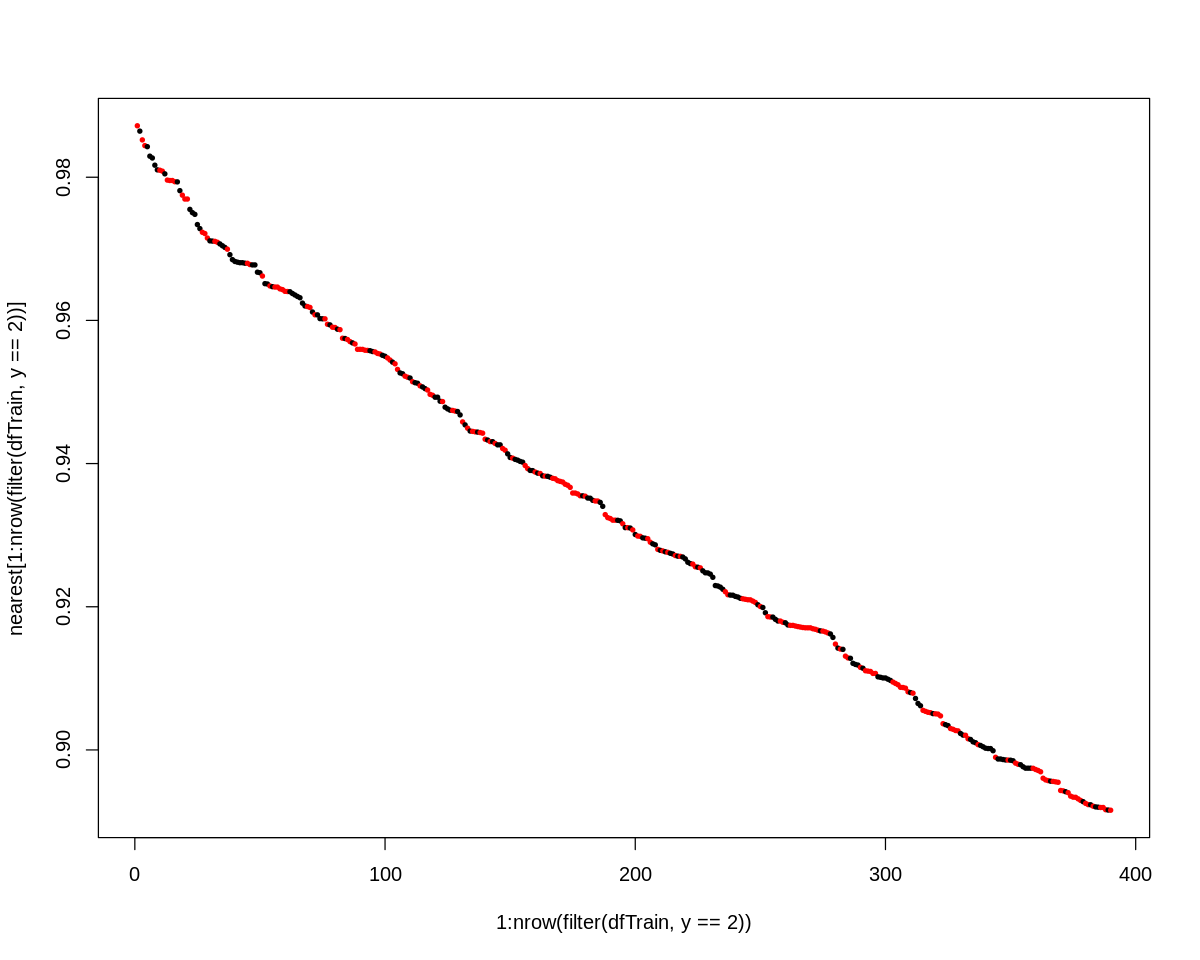

In [ ]:
nearest <- sort( cosines( dls[,1:4], wils[1:4] ), decreasing=T )
ycols2 <- rep( "black", nrow(dfTrain) ) #Create a list with all "black" colors
ycols2[ y == '2' ] <- "red" #Puts as red the news from "trade" topic
plot(1:nrow(filter(dfTrain, y==2)), nearest[1:nrow(filter(dfTrain, y==2))], pch=20, cex=0.7, col=ycols2[strtoi(names(nearest))] )

###A better query

We define here a function to fasten the calculation of similarity between a query and terms in LSA

In [ ]:
makequery <- function(Q, TDM, LSA) {
  V <- query( Q, rownames(TDM) )
  LS <- t(V) %*% LSA$tk
  DK <- LS %*% diag(LSA$sk^-1)
  DKSRS <- DK %*% diag(sqrt(LSA$sk))
  list( query=Q, bin=V, dk=DK, ls=LS, dksrs=DKSRS )
}

For example, by looking at the wordcloud we can choose some words which would help us getting a better query for finding news from "trade" topic - 
i.e. trade, surplus, import, export, japan

In [ ]:
iei <- makequery( "trade surplus import export secretari accord", tdm2, lsar )
dfTrain$text[top(cosines(dls[,1:4],iei$ls[1:4]),10)]
table( y[ top( cosines( dls[,1:4], iei$ls[1:4] ), nrow(filter(dfTrain, y==2)) ) ] )

[1] " finland had a 641 mln markka trade surplus in february following an 80 mln markka surplus in january and a 614 mln surplus in february 1986 customs board preliminary figures showed exports in february were 6 38 billion markka and imports 5 74 billion compared with exports of 6 72 billion and imports of 6 64 billion in january and exports of 6 92 billion and imports of 6 31 billion in february last year reuter 3"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
 [2] " canada had a trade surplus of 1 25 billion dlrs in february compared with an upward revised 623 mln dlrs surplus in january statistics canada said the january surplus originally was reported at 533 mln dlrs the february surplus last year was 189 mln dlrs february exports seasonally adjusted were 10 44 billion dlrs against 9 85 billion in january and 10 05 billion in february 1986 february imports were 9 19 billion dlrs against 9 23 billion in january and 9 86 billion in february 1986 reuter 3"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  


  1   2   3   4 
 27 272   3  88 

#Text classification


##Train set preprocessing
First, we preprocess the input in order to feed it to the models that we will create. So, we convert the term-document matrix to a document-term one and then create a data.frame

In [ ]:
dtm <- as.DocumentTermMatrix(tdm2) #Convert the termDocument matrix to a documenTerm one
m <- as.matrix(dtm) #Convert to generic matrix
data<-data.frame(m) #Create a datafrmae
data<-cbind(dfTrain[, 1],data)
colnames(data)[1]="y"
data

,y,accord,agreement,agricultur,depart,end,export,grain,march,report,⋯,chang,day,intern,set,deficit,dollar,money,effect,barrel,crude
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.06345355,0.10342046,0.05603970,0.06332314,0.11146343,0.03969030,0.14189180,0.12849518,0.04665812,⋯,0,0,0,0,0,0,0,0,0,0
2,1,0.00000000,0.01149116,0.00000000,0.00000000,0.00000000,0.00000000,0.06306302,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
3,1,0.00000000,0.00000000,0.04522502,0.10220577,0.00000000,0.03203077,0.00000000,0.00000000,0.03765393,⋯,0,0,0,0,0,0,0,0,0,0
4,1,0.08339609,0.13592403,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
5,1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04149441,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
6,1,0.22452794,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.25103934,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
7,1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.10143077,0.12087079,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
8,1,0.00000000,0.00000000,0.05603970,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
9,1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.14044260,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0


##Test set preprocessing
We apply the same pre-processing we did in the Section 2.3 to the test set, to get a corpus with the same format and terms

In [ ]:
##TEXT CLEANING##
colnames(dfTest)[2] <- "text"
dfTest$doc_id <- rownames(dfTest)
corpus_test <- Corpus(DataframeSource(data.frame(dfTest[, c(3,2)])))
corpus_test <- tm_map(corpus_test, content_transformer(tolower))
corpus_test <- tm_map(corpus_test, function(x) removeWords(x, stopwords("english")))
corpus_test <- tm_map(corpus_test, stemDocument)
corpus_test <- tm_map(corpus_test, removeNumbers)
otherWords<- c("said", "billion", "dlrs", "mln", "pct", "reuter")
corpus_test <- tm_map(corpus_test, function(x) removeWords(x, otherWords))

##CREATING OF DOCUMENT TERM MATRIX DATA.FRAME ##
tdm_test <- TermDocumentMatrix(corpus_test,control=list(weighting=weightTfIdf, dictionary=colnames(dtm))) #First create term-doc matrix
tdm_test2<-removeSparseTerms(tdm_test, 0.90) #Remove sparse rows
dtm_test <- as.DocumentTermMatrix(tdm_test2) #Convert to doc-term matrix
m_test <- as.matrix(dtm_test) #Convert to generic matrix

Since in the test data may occur words that do not appeear in train data, we need some more preprocessing. 

In particular, we will not keep the unseen words and cut the test dictionary to the words that appear only in the train data. 
In case a word is present in the train data and not in test, we will set values of the unseen terms in test matrix to 0s.

In [ ]:
#xx is a data.frame of the test data which contains only the terms that appear both in train and test data
#This is done by applying the intersection to the list of terms (colnames) off each matrix
xx <- data.frame(m_test[,intersect(colnames(m_test),
                                    colnames(m))])
##yy is a matrix of 0s which contains terms that are in train data but not test data
yy <- matrix(0, 
              nrow = nrow(dfTest), #Row dimension: number of documents in test data
              ncol = length(setdiff(colnames(m), colnames(m_test))), #Column dimension: Length of list of terms that are in train but not test data
              dimnames = list(c(1:nrow(dfTest)),setdiff(colnames(m),colnames(m_test)))) #Sets dimension names
zz<-cbind(xx,yy) #Stacks horizontally the two created matrices
dim(m)
dim(zz)

#Creates test data.frame
test_data <- data.frame(zz)
test_data <- cbind(dfTest[, 1], test_data)
colnames(test_data)[1]="y"
test_data

[1] 1815  131

[1] 420 131

,y,agricultur,chang,depart,fall,grain,high,industri,last,lower,⋯,remain,japanes,financ,european,note,issu,well,general,ask,effect
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.07459592,0.21826035,0.07998265,0.07926718,0.08457522,0.2421345,0.05674421,0.03912051,0.08377123,⋯,0,0,0,0,0,0,0,0,0,0
2,1,0.07077049,0.00000000,0.07588097,0.07520220,0.00000000,0.0000000,0.00000000,0.03711433,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
3,1,0.00000000,0.00000000,0.00000000,0.00000000,0.31292830,0.0000000,0.04199071,0.00000000,0.06199071,⋯,0,0,0,0,0,0,0,0,0,0
4,1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
5,1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
6,1,0.00000000,0.04984959,0.00000000,0.00000000,0.00000000,0.0000000,0.03888029,0.05360959,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
7,1,0.00000000,0.00000000,0.00000000,0.00000000,0.18407547,0.1756662,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
8,1,0.17250308,0.00000000,0.55487963,0.00000000,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0
9,1,0.00000000,0.00000000,0.00000000,0.00000000,0.36815094,0.0000000,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0,0,0,0,0


##k-NN

The first model is a kNN already implemented in the caret library. We will perform training with 10 fold Cross Validation and repeat training 3 times for each of the model we will create - it is important to have the same train control for all models in order to compare them later.

With tuneLenght=4, we will tune the k parameter with 4 odd numbers (5-7-9-11) - it starts from 5 by default.

It happens to be that the best k parameter is k=9

In [ ]:
#Set a seed for reproducibility
seed <- 42 
set.seed(seed)

ctrl <- trainControl(method="repeatedcv",number = 10, repeats = 3) #Training with 10 Cross Validation - Repeats training 3 times

start <- Sys.time()
knn <- train(as.factor(y) ~ ., data = data, method = "knn", trControl = ctrl, tuneLength = 4)
print(Sys.time() - start)
knn

Time difference of 9.378314 secs


k-Nearest Neighbors 

1815 samples
 131 predictor
   4 classes: '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1634, 1633, 1634, 1634, 1633, 1633, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.8495715  0.7983475
   7  0.8528813  0.8028055
   9  0.8528833  0.8028120
  11  0.8504953  0.7995738

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.

The best model is with k=7 and has an accuracy of 85.28% with Kappa=0.8028

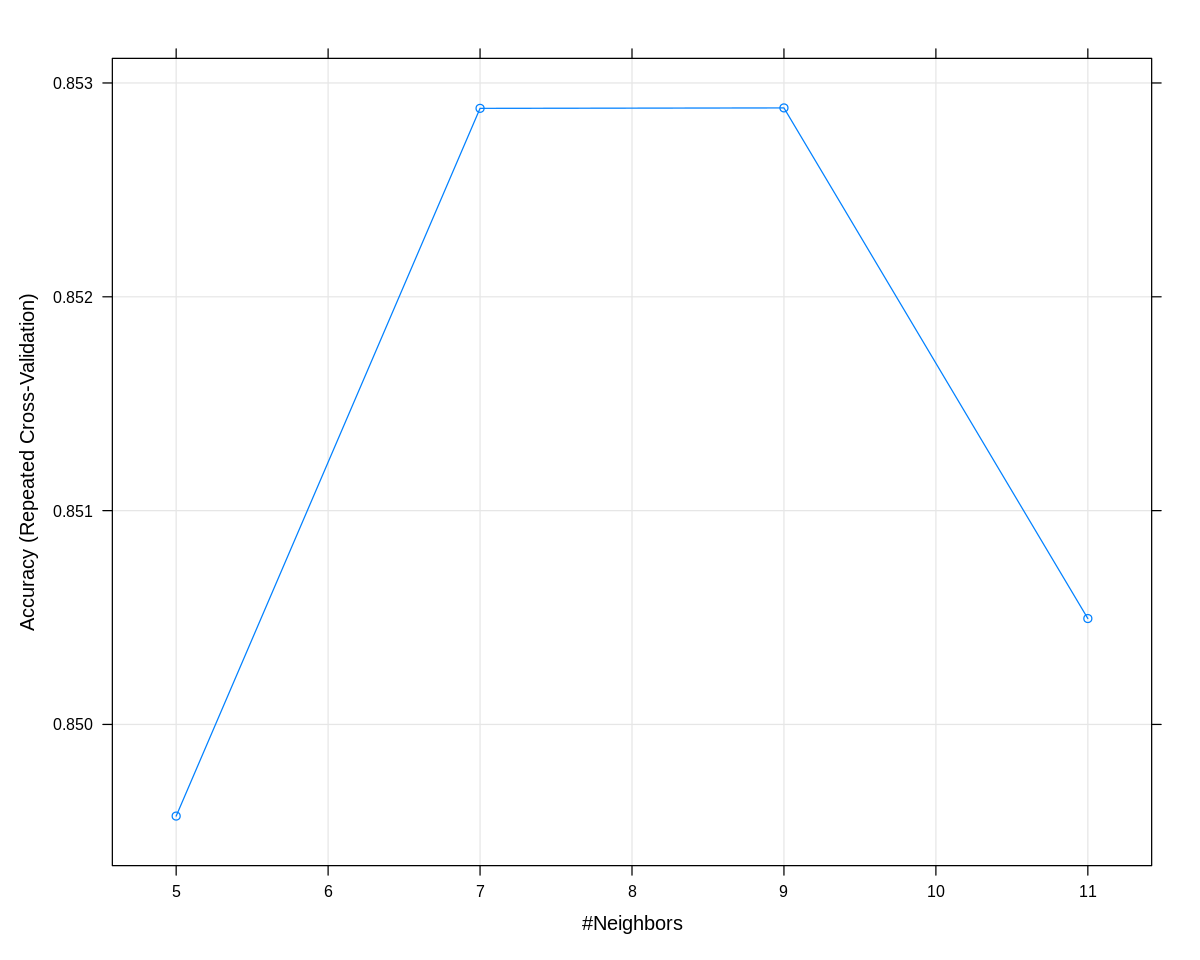

In [ ]:
plot(knn)

Let's see how it performs on test data.

In [ ]:
knn.predict <- predict(knn, newdata = test_data) #Predict over test set

Caret confusionMatrix function provides us different metrics:

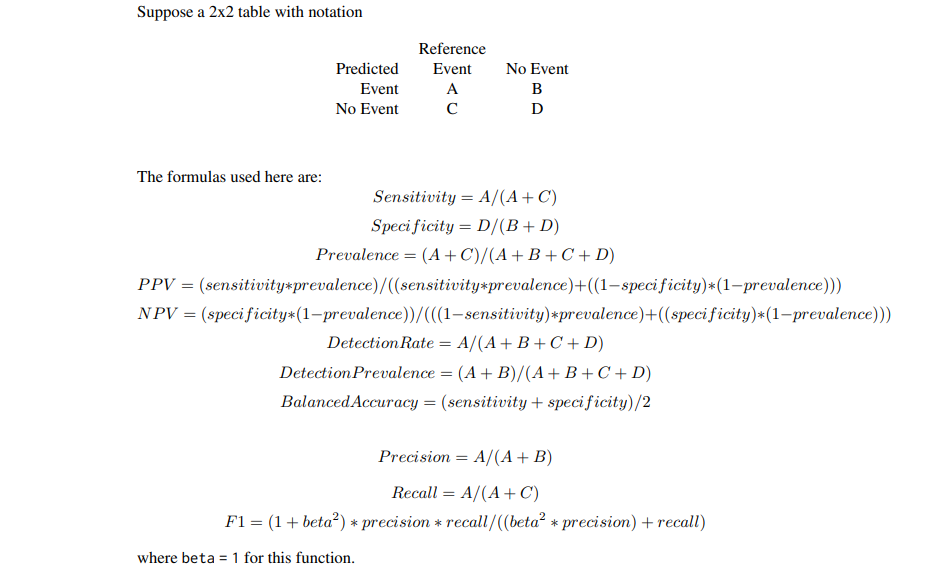

In [ ]:
confusionMatrix(knn.predict, as.factor(dfTest$y), dnn=c("Prediction", "Reference")) #Creates the confusion matrix

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4
         1  83   5   3   6
         2   8  71   5  17
         3   7   2  88   2
         4   7   5   3 108

Overall Statistics
                                          
               Accuracy : 0.8333          
                 95% CI : (0.7942, 0.8677)
    No Information Rate : 0.3167          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7767          
                                          
 Mcnemar's Test P-Value : 0.1088          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7905   0.8554   0.8889   0.8120
Specificity            0.9556   0.9110   0.9657   0.9477
Pos Pred Value         0.8557   0.7030   0.8889   0.8780
Neg Pred Value         0.9319   0.9624   0.9657   0.9158
Prevalence             0.2500   0.1976   0.2357   0.3167
Detection Rate         0.1976   0.1690  

##SVM

SVM finds an hyperplane that separates better points in a space. We will try both SVM with linear kernel and RBF kernel. In the linear one the parameter C is constant while in RBF we will tune the cost with 5 different values from 0.25 to 4.

SVM doesn't seem to perform well on this dataset - we will compare the models later.

In [ ]:
start <- Sys.time()
svm.linear  <- train(as.factor(y) ~ . , data=data, trControl = ctrl, method = "svmLinear")
end <- Sys.time() - start
print(end)
svm.linear

Time difference of 15.63566 secs


Support Vector Machines with Linear Kernel 

1815 samples
 131 predictor
   4 classes: '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1632, 1633, 1634, 1634, 1634, 1633, ... 
Resampling results:

  Accuracy   Kappa    
  0.8306257  0.7732009

Tuning parameter 'C' was held constant at a value of 1

In [ ]:
start <- Sys.time()
svm.radial  <- train(as.factor(y) ~ . , data=data, trControl = ctrl, method = "svmRadial", tuneLength = 5)
end <- Sys.time() - start
print(end)
svm.radial

Time difference of 2.005813 mins


Support Vector Machines with Radial Basis Function Kernel 

1815 samples
 131 predictor
   4 classes: '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1633, 1633, 1634, 1634, 1633, 1634, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.8513953  0.8001174
  0.50  0.8693917  0.8245987
  1.00  0.8706697  0.8263819
  2.00  0.8680965  0.8229429
  4.00  0.8668134  0.8212509

Tuning parameter 'sigma' was held constant at a value of 0.005099653
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.005099653 and C = 1.

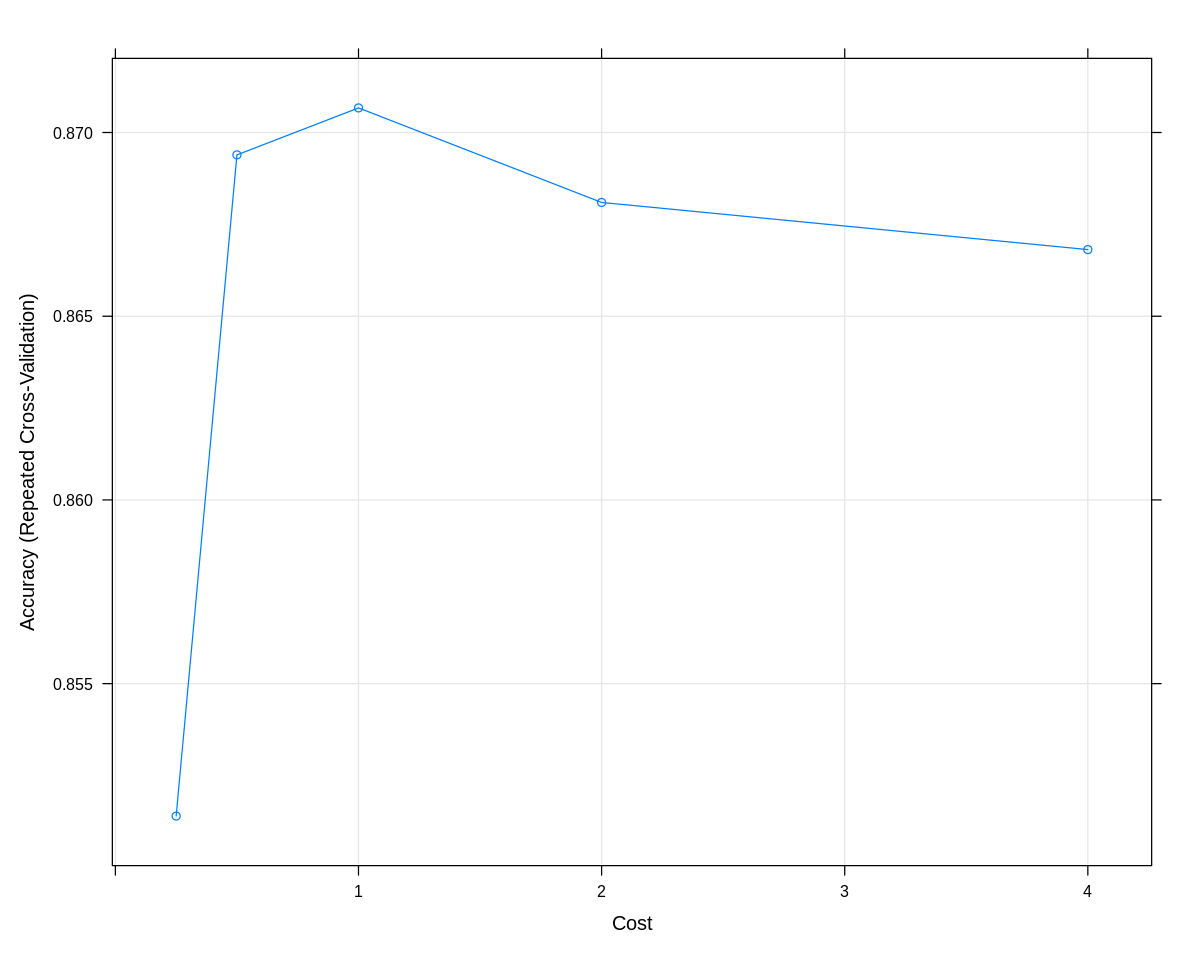

In [ ]:
plot(svm.radial)

In [ ]:
#predict on test data
svm.linear.predict <- predict(svm.linear,newdata = test_data)
svm.radial.predict <- predict(svm.radial,newdata = test_data)

In [ ]:
confusionMatrix(svm.linear.predict, as.factor(dfTest$y), dnn=c("Prediction", "Reference"))

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4
         1  86   9   7   8
         2  12  67   8  14
         3   1   2  80   6
         4   6   5   4 105

Overall Statistics
                                          
               Accuracy : 0.8048          
                 95% CI : (0.7636, 0.8416)
    No Information Rate : 0.3167          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.7385          
                                          
 Mcnemar's Test P-Value : 0.03605         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8190   0.8072   0.8081   0.7895
Specificity            0.9238   0.8991   0.9720   0.9477
Pos Pred Value         0.7818   0.6634   0.8989   0.8750
Neg Pred Value         0.9387   0.9498   0.9426   0.9067
Prevalence             0.2500   0.1976   0.2357   0.3167
Detection Rate         0.2048   0.1595  

In [ ]:
confusionMatrix(svm.radial.predict, as.factor(dfTest$y), dnn=c("Prediction", "Reference"))

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4
         1  27   4   0   0
         2   3  41   2   3
         3   1   0  33   0
         4  74  38  64 130

Overall Statistics
                                         
               Accuracy : 0.55           
                 95% CI : (0.501, 0.5983)
    No Information Rate : 0.3167         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.365          
                                         
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity           0.25714  0.49398  0.33333   0.9774
Specificity           0.98730  0.97626  0.99688   0.3868
Pos Pred Value        0.87097  0.83673  0.97059   0.4248
Neg Pred Value        0.79949  0.88679  0.82902   0.9737
Prevalence            0.25000  0.19762  0.23571   0.3167
Detection Rate        0.06429  0.09762  0.07857  

Performances on test set, gets even worse so this means it does not generalize well and maybe a better feature selection has to be done. 

By looking at the confusion matrix on test set we can clearly see that our model overfits on class 4 (money-fx) - maybe with the application of class weights and giving less weight to the "money-fx" class we could get better results.

##Naive Bayes

No particular hyperparameters tuning can be done on Naive Bayes so we will run the default model.

In [ ]:
start <- Sys.time()
nb <- train(as.factor(y) ~ . , data=data, trControl = ctrl, method = "nb")
print(Sys.time()-start)
nb

Time difference of 1.600874 mins


Naive Bayes 

1815 samples
 131 predictor
   4 classes: '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1633, 1634, 1634, 1633, 1633, 1632, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy  Kappa    
  FALSE           NaN        NaN
   TRUE      0.752043  0.6687975

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were fL = 0, usekernel = TRUE and adjust
 = 1.

In [ ]:
nb.predict <- predict(nb ,newdata = test_data)

In [ ]:
confusionMatrix(nb.predict, as.factor(dfTest$y), dnn=c("Prediction", "Reference"))

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38  7 12  3
         2 17 44  8 24
         3 39 18 70 15
         4 11 14  9 91

Overall Statistics
                                          
               Accuracy : 0.5786          
                 95% CI : (0.5297, 0.6263)
    No Information Rate : 0.3167          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4355          
                                          
 Mcnemar's Test P-Value : 2.524e-05       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity           0.36190   0.5301   0.7071   0.6842
Specificity           0.93016   0.8546   0.7757   0.8815
Pos Pred Value        0.63333   0.4731   0.4930   0.7280
Neg Pred Value        0.81389   0.8807   0.8957   0.8576
Prevalence            0.25000   0.1976   0.2357   0.3167
Detection Rate        0.09048   0.1048   0.1667   0.2167
Det

We get similar results to the SVM model but the cause may be not the same, since we get errors in predictions on all classes. Here, we cannot do too much. Maybe our data is not good for probabilistic models.

##Random Forest

For random forest in the caret packge we can tune only one parameter which is "mtry, namely the number of variables randomly sampled as candidates at each split. 

We will create a tune grid a perform a grid search over 4 different mtry values.

This seems to be the best model with high accuracy on test set, the smallest confidence interval with 95% confidence and highest Kappa statistic value.

In [ ]:
#create tunegrid with 15 values from 1:15 for mtry to tunning model. Our train function will change number of entry variable at each split according to tunegrid. 
tunegrid <- expand.grid(mtry=c(1,2,3,5)) 
start <- Sys.time()
rf_gridsearch <- train(as.factor(y) ~ ., 
                       data = data,
                       method = 'rf',
                       metric = 'Accuracy',
                       tuneGrid = tunegrid,
                       trControl = ctrl)
print(Sys.time()-start)
rf_gridsearch

Time difference of 15.75962 mins


Random Forest 

1815 samples
 131 predictor
   4 classes: '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1634, 1634, 1634, 1632, 1633, 1633, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  1     0.8703337  0.8258369
  2     0.8932894  0.8569222
  3     0.8956835  0.8601095
  5     0.8969797  0.8617758

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 5.

In [ ]:
rf_gridsearch.predict <- predict(rf_gridsearch ,newdata = test_data)
confusionMatrix(rf_gridsearch.predict, as.factor(dfTest$y), dnn=c("Prediction", "Reference"))

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4
         1  87   5   1   2
         2   6  68   3   4
         3   3   2  92   3
         4   9   8   3 124

Overall Statistics
                                          
               Accuracy : 0.8833          
                 95% CI : (0.8487, 0.9124)
    No Information Rate : 0.3167          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8425          
                                          
 Mcnemar's Test P-Value : 0.3136          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8286   0.8193   0.9293   0.9323
Specificity            0.9746   0.9614   0.9751   0.9303
Pos Pred Value         0.9158   0.8395   0.9200   0.8611
Neg Pred Value         0.9446   0.9558   0.9781   0.9674
Prevalence             0.2500   0.1976   0.2357   0.3167
Detection Rate         0.2071   0.1619  

##Compare ML models

We will compare the models by collecting resamples - we will get percentiles, mean, median, min and max values of accuracies and kappa statistics collected on cv and repetetitions of the training. This can be done only on models trained with the same train control. So we will collect this only for machine learning models trained with caret.

In general, we want a model with the smallest range between min and max values and the one with highest median.

We can clearly see that the best model is the RandomForest for both metrics.


Call:
summary.resamples(object = results)

Models: KNN, SVMLinear, SVMRadial, NaiveBayes, RandomForest 
Number of resamples: 30 

Accuracy 
                  Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
KNN          0.7692308 0.8321975 0.8563536 0.8528833 0.8719092 0.9175824    0
SVMLinear    0.7790055 0.8082691 0.8337937 0.8306257 0.8506215 0.8846154    0
SVMRadial    0.8296703 0.8563536 0.8732773 0.8706697 0.8844560 0.9120879    0
NaiveBayes   0.6758242 0.7292818 0.7582418 0.7520430 0.7771538 0.8076923    0
RandomForest 0.8508287 0.8846154 0.8958896 0.8969797 0.9119665 0.9281768    0

Kappa 
                  Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
KNN          0.6903508 0.7751160 0.8073562 0.8028120 0.8281728 0.8897192    0
SVMLinear    0.7044295 0.7440869 0.7772057 0.7732009 0.7998427 0.8454071    0
SVMRadial    0.7710599 0.8072713 0.8295564 0.8263819 0.8451606 0.8818901    0
NaiveBayes   0.5665617 0.6384877 0.6766394 0.6687975 0.7021119 0.742896

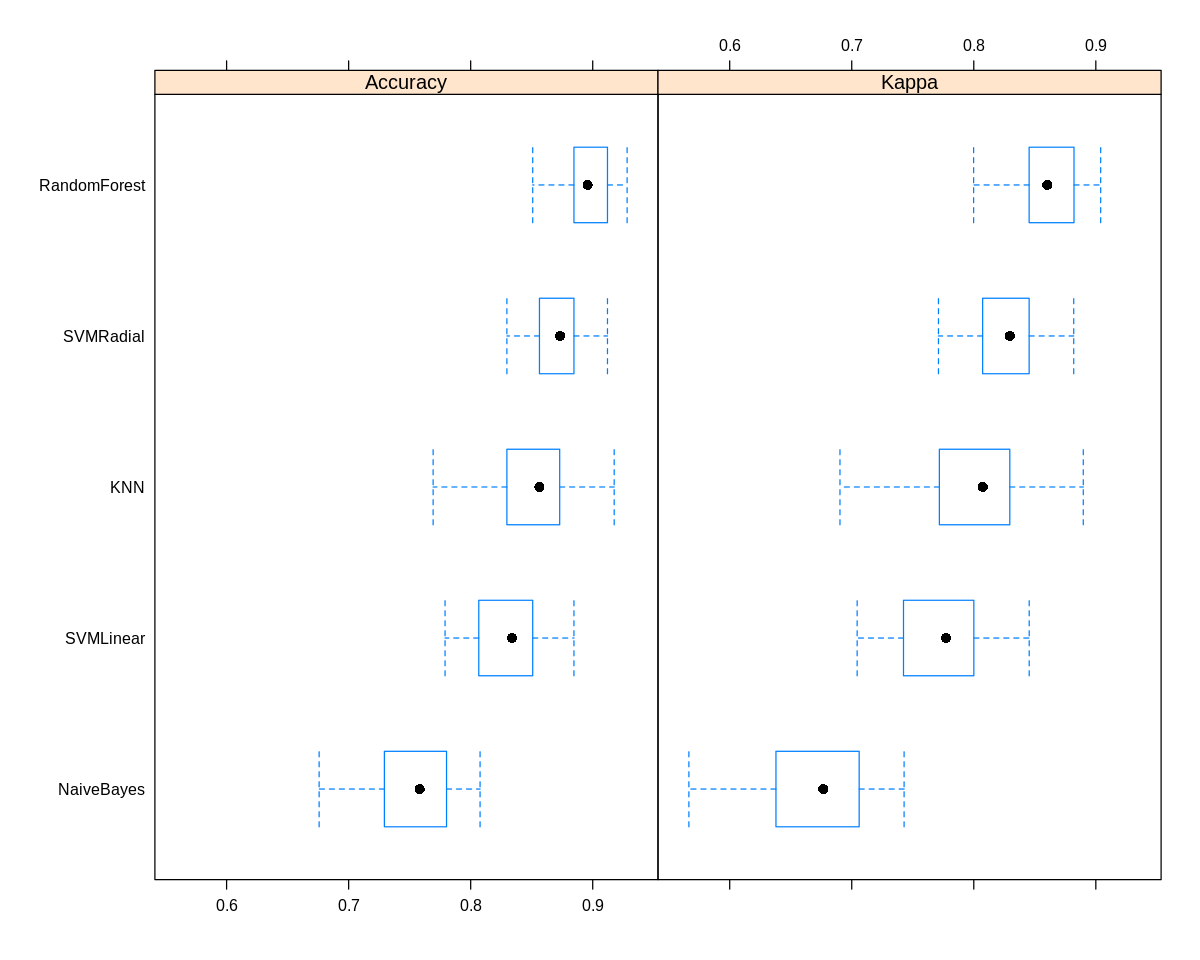

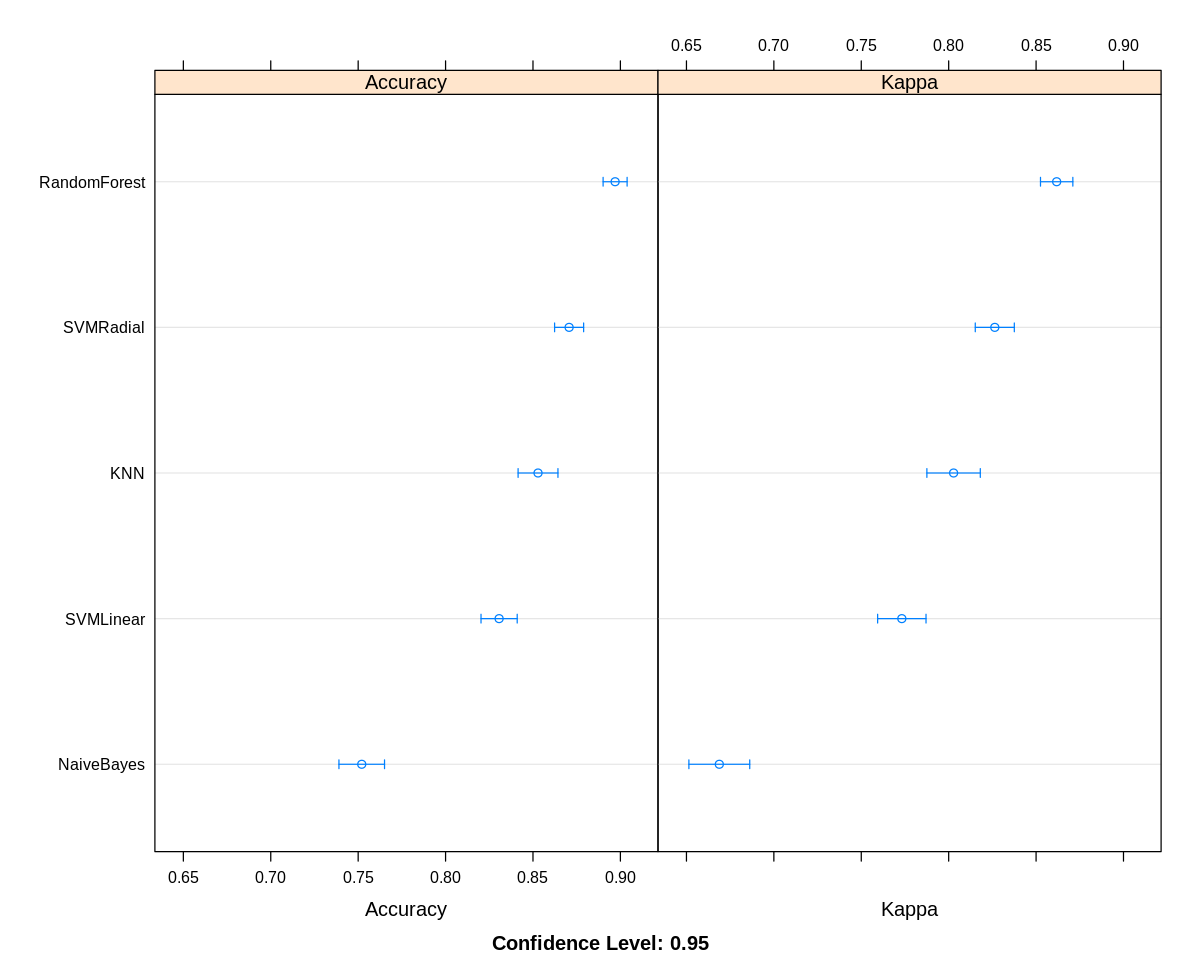

In [ ]:
results <- resamples(list(KNN=knn, SVMLinear=svm.linear, SVMRadial=svm.radial, NaiveBayes=nb, RandomForest=rf_gridsearch)) #collect resamples
summary(results) # summarize the distributions
bwplot(results) # boxplots of results
dotplot(results) # dot plots of results

## 2 stacked LSTMs
In order to train an LSTM we need to feed sequences as input so we set a maxlen value which is equal to 150. 

We will reload the dataset and use all the tokens available for this deep learning model, to see how it performs without particular feature selection.

Since sequences have to be of the same length we pad them.

In [72]:
set.seed(42) # Set seed
word_index <- dataset_reuters_word_index()
max_features <- length(word_index) #WE select all words in the dataset
maxlen <- 150 #Max length of sequences that have to be fed to the NN

#Reload the dataset
reuters <- dataset_reuters(num_words = max_features)
c(c(x_train, y_train), c(x_test, y_test)) %<-% reuters

#Pad sequences to make them of the same length
x_train <- pad_sequences(x_train, maxlen = maxlen)
x_test <- pad_sequences(x_test, maxlen = maxlen)

Then, we filter the dataset with the classes chosen before, and one-hot encode the labels.

In [73]:
x_train <- x_train[y_train %in% c(1,11,16,19),]
y_train <- y_train[y_train %in% c(1,11,16,19)]

y_train[y_train==1] <- 0
y_train[y_train==11] <- 1
y_train[y_train==16] <- 2
y_train[y_train==19] <- 3
table(y_train)
one_hot_y_train <- to_categorical(y_train) #one-hot encode labels

y_train
  0   1   2   3 
432 390 444 549 

We create the Sequential Model made by:
* Embedding layer for word embeddings
* Dropout to prevent overfitting
* LSTM layer with return_sequences=True (to stack multiple LSTMs)
* Another LSTM layer
* Dense layer with 4 units (# classes) and softmax function to return probabilieties

We will use RMSprop optimizer. Since we are addressing a multi-class problem, and we have used a Dense layer with softmax function, we need to use as loss function the categorical cross entropy.

In [74]:
# Create the model architecture
model <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_features, output_dim = 32,input_length = maxlen) %>% #Embedding layer
  layer_dropout(rate = 0.2) %>%
  layer_lstm(units=128,dropout=0.2,return_sequences = TRUE) %>% #First LSTM
  layer_lstm(units=64,dropout=0.2) %>%
  layer_dense(units = 4, activation = "softmax")

# Compile model with metric, optimizer and loss function
model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("acc")
)
summary(model)

#Train model
history <- model %>% fit(
  x_train, one_hot_y_train,
  epochs = 10,
  batch_size = 32,
  validation_split = 0.2,
  verbose=2)

Model: "sequential_14"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 embedding_14 (Embedding)           (None, 150, 32)                 991328      
                                                                                
 dropout_14 (Dropout)               (None, 150, 32)                 0           
                                                                                
 lstm_14 (LSTM)                     (None, 150, 128)                82432       
                                                                                
 lstm_13 (LSTM)                     (None, 64)                      49408       
                                                                                
 dense_14 (Dense)                   (None, 4)                       260         
                                                                                
Total

In [76]:
history


Final epoch (plot to see history):
    loss: 0.08331
     acc: 0.98
val_loss: 0.6287
 val_acc: 0.8264 

`geom_smooth()` using formula 'y ~ x'



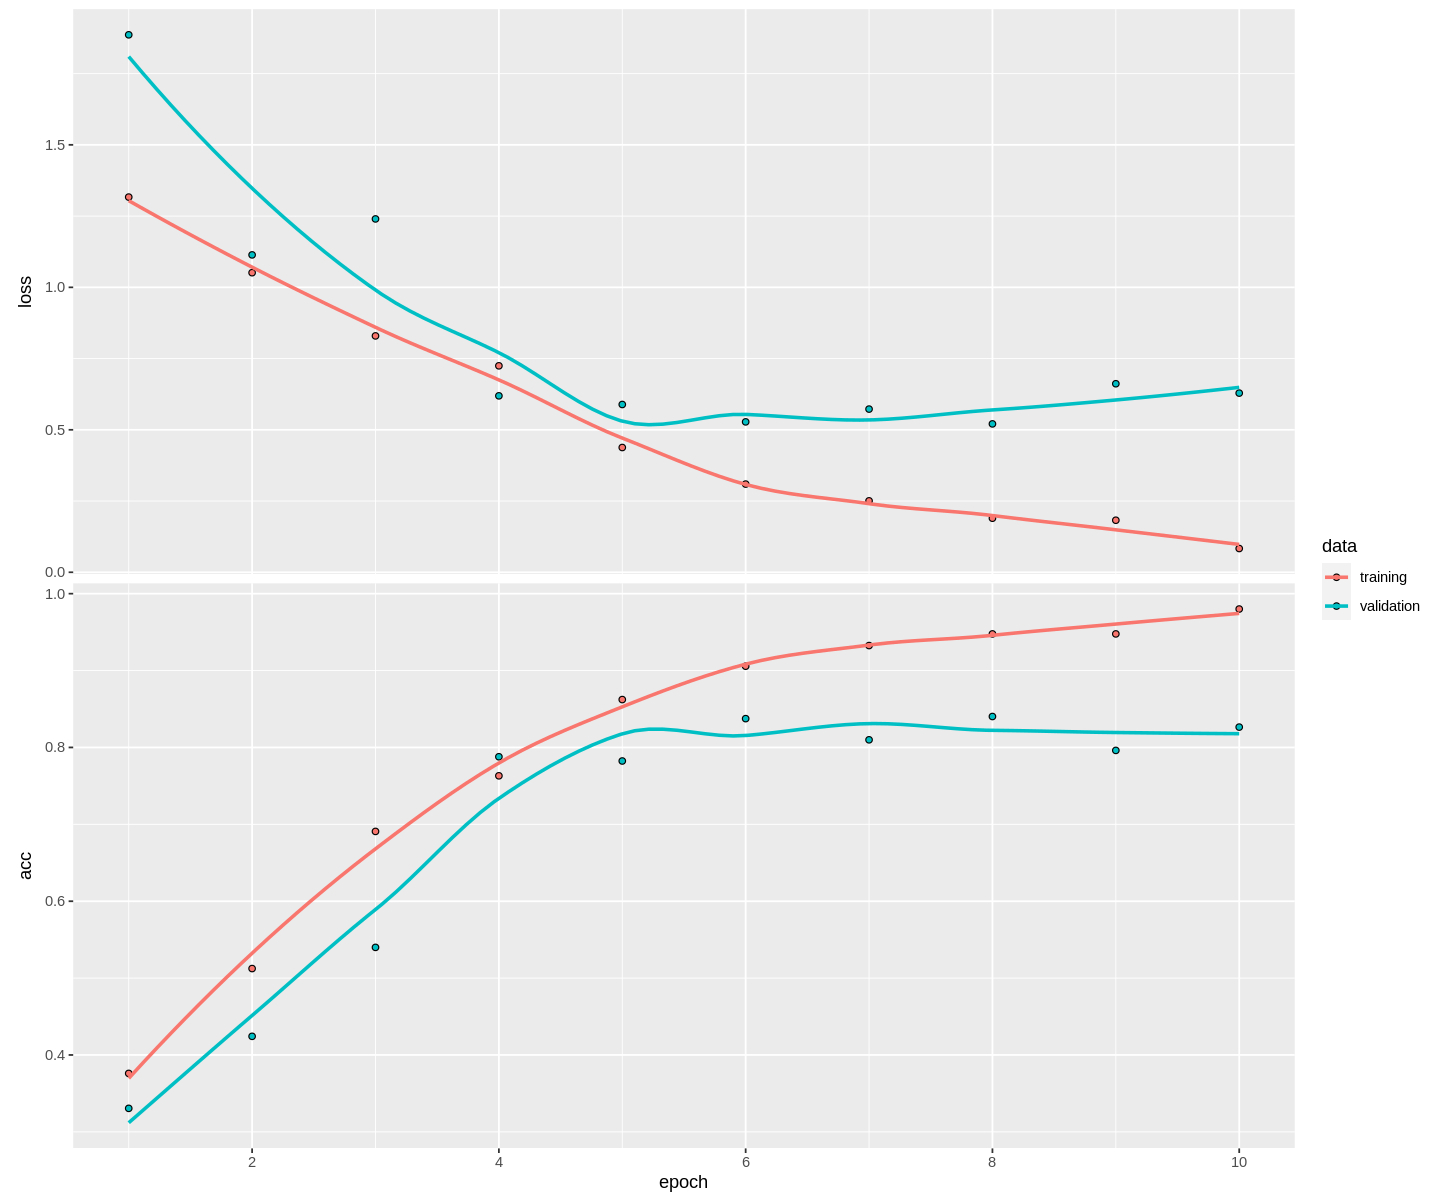

In [77]:
options(repr.plot.width=12, repr.plot.height=10)
plot(history)

Begin to overfit at epoch 8.

We filter also the test data classes and then one-hot encode the labels in order to use the evaluate function from keras.

In [78]:
x_test <- x_test[y_test %in% c(1,11,16,19),]
y_test <- y_test[y_test %in% c(1,11,16,19)]

y_test[y_test==1] <- 0
y_test[y_test==11] <- 1
y_test[y_test==16] <- 2
y_test[y_test==19] <- 3
table(y_test)
one_hot_y_test <- to_categorical(y_test)

y_test
  0   1   2   3 
105  83  99 133 

In [79]:
evaluate(model, x_test, one_hot_y_test)

loss       acc 
0.7053677 0.8214286

## Bidirectional GRU

We will create a Bidirectional GRU to check whether it performs better than LSTM

In [95]:
# Create the model architecture
bigru <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_features, output_dim = 32,input_length = maxlen) %>% #Embedding layer
  layer_dropout(rate = 0.2) %>%
  bidirectional(layer_gru(units=128,dropout=0.2, return_sequences = TRUE)) %>%
  bidirectional(layer_gru(units=64,dropout=0.2)) %>%
  layer_dense(units = 4, activation = "softmax")

# Compile model with metric, optimizer and loss function
bigru %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("acc")
)
summary(bigru)

#Train model
history.bigru <- bigru %>% fit(
  x_train, one_hot_y_train,
  epochs = 10,
  batch_size = 32,
  validation_split = 0.2,
  verbose=2)

Model: "sequential_20"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 embedding_20 (Embedding)           (None, 150, 32)                 991328      
                                                                                
 dropout_20 (Dropout)               (None, 150, 32)                 0           
                                                                                
 bidirectional_14 (Bidirectional)   (None, 150, 256)                124416      
                                                                                
 bidirectional_13 (Bidirectional)   (None, 128)                     123648      
                                                                                
 dense_20 (Dense)                   (None, 4)                       516         
                                                                                
Total

In [96]:
history.bigru


Final epoch (plot to see history):
    loss: 0.03604
     acc: 0.9931
val_loss: 1.023
 val_acc: 0.7438 

`geom_smooth()` using formula 'y ~ x'



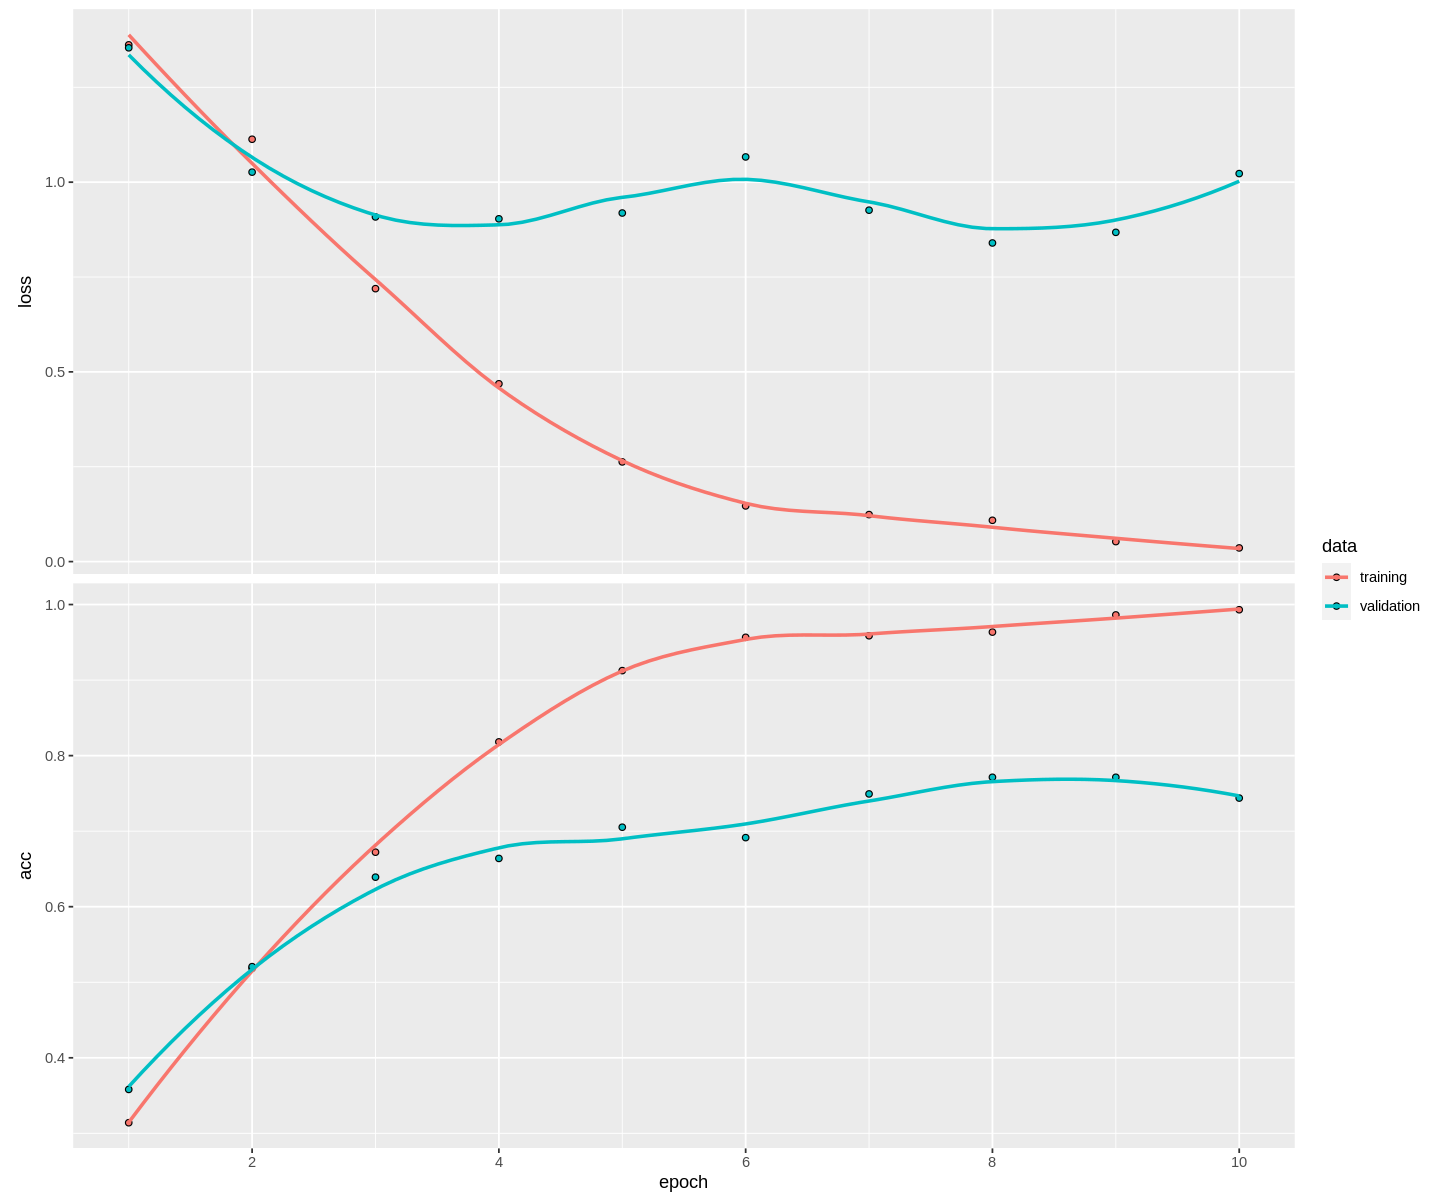

In [97]:
plot(history.bigru)

In [98]:
evaluate(bigru, x_test, one_hot_y_test)

loss       acc 
1.4469602 0.7095238

The Bidirectional-GRU model reaches really high accuracy, but as we can see from the plot it clearly overfits training data.

We can check this further by evaluating the test data - indeed accuracy is a lot lower on test set.